In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time, datetime
%matplotlib inline
import statsmodels.api as sm
import warnings
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



from tqdm import tqdm_notebook
from itertools import product
from collections import defaultdict
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Cleaning X data

In [3]:
df_X = pd.read_csv("/content/salpani_WB__22.5654N_ 87.1554E_dataset_nasa.csv", skiprows=14)

In [4]:
new_header = df_X.iloc[0]
df_X = df_X[1:]
df_X.columns = new_header

In [5]:
df_X['date'] = df_X['YEAR'].astype(str) + '-' + df_X['MO'].astype(str) + '-' + df_X['DY'].astype(str)
df_X['date'] = pd.to_datetime(df_X['date'], format='%Y-%m-%d')

In [6]:
df_X.drop(columns=['YEAR', 'MO', 'DY'], axis=1, inplace=True)

In [7]:
cols = df_X.columns.tolist()

In [8]:
cols = cols[-1:] + cols[:-1]

In [9]:
df_X = df_X[cols]

In [10]:
df_X = df_X.drop([i for i in range(1, 19)]).reset_index(drop=True)

In [11]:
df_X['HR'] = pd.to_numeric(df_X['HR'])

In [12]:
df_X['date'] = pd.to_datetime(df_X['date']) + pd.to_timedelta(df_X['HR'], unit='h')

In [13]:
df_X.drop(columns=['HR'], axis=1, inplace=True)

we don't have the `ALLSKY_SFC_SW_DWN` and `CLRSKY_SFC_SW_DWN` for the data after 2-12-2022

### Cleaning y data

In [15]:
df_y = pd.read_excel('/content/HOURLY PV POWER GENERATION SHEET-suvendu.xlsx', skiprows=2)

In [16]:
df_y.rename(columns={'Unnamed: 0': 'date', 'Unnamed: 14': 'EXPORT GENERATION(MWH)', 'Unnamed: 15': 'IMPORT GENERATION(KWH)',
                     'Unnamed: 16': 'NET EXPORT GENRATION(MWH)', 'Unnamed: 17': 'GRID INTERRUPTION(MIN)'}, inplace=True)

In [17]:
df_y.drop(columns=['Unnamed: 18'], axis=1, inplace=True)

In [18]:
df_y = df_y.reset_index(drop=True)

In [19]:
df_y = df_y.drop(range(1, 9), axis=0).reset_index(drop=True)
df_y.drop([0], inplace=True)

In [20]:
df_y[[time(i) for i in range(0, 6)]] = pd.DataFrame([[0 for _ in range(6)]], index=df_y.index)
df_y[[time(i) for i in range(19, 24)]] = pd.DataFrame([[0 for _ in range(5)]], index=df_y.index)

In [21]:
cols = df_y.columns.tolist()
for i, j in enumerate(cols):
  print(i, j)

0 date
1 06:00:00
2 07:00:00
3 08:00:00
4 09:00:00
5 10:00:00
6 11:00:00
7 12:00:00
8 13:00:00
9 14:00:00
10 15:00:00
11 16:00:00
12 17:00:00
13 18:00:00
14 EXPORT GENERATION(MWH)
15 IMPORT GENERATION(KWH)
16 NET EXPORT GENRATION(MWH)
17 GRID INTERRUPTION(MIN)
18 00:00:00
19 01:00:00
20 02:00:00
21 03:00:00
22 04:00:00
23 05:00:00
24 19:00:00
25 20:00:00
26 21:00:00
27 22:00:00
28 23:00:00


In [22]:
cols = cols[:1] + cols[18:24] + cols[1:14] + cols[24:29] + cols[14:18]

In [23]:
df_y = df_y[cols]

In [24]:
df_y = df_y.melt(id_vars=["date", "EXPORT GENERATION(MWH)", "IMPORT GENERATION(KWH)", "NET EXPORT GENRATION(MWH)", "GRID INTERRUPTION(MIN)"],
        var_name="Hour",
        value_name="Value")

In [25]:
df_y = df_y.sort_values(by = ["date", "EXPORT GENERATION(MWH)", "IMPORT GENERATION(KWH)", "NET EXPORT GENRATION(MWH)", "GRID INTERRUPTION(MIN)"])

In [26]:
df_y = df_y.reset_index(drop=True)

In [27]:
cols = df_y.columns.tolist()
cols = cols[:1] + cols[-2:] + cols[1:5]
df_y = df_y[cols]

In [28]:
df_y

date      Hour Value  EXPORT GENERATION(MWH)  \
0     2019-02-10  00:00:00     0                   57.40   
1     2019-02-10  01:00:00     0                   57.40   
2     2019-02-10  02:00:00     0                   57.40   
3     2019-02-10  03:00:00     0                   57.40   
4     2019-02-10  04:00:00     0                   57.40   
...          ...       ...   ...                     ...   
37723 2023-05-31  19:00:00     0                   44.15   
37724 2023-05-31  20:00:00     0                   44.15   
37725 2023-05-31  21:00:00     0                   44.15   
37726 2023-05-31  22:00:00     0                   44.15   
37727 2023-05-31  23:00:00     0                   44.15   

       IMPORT GENERATION(KWH)  NET EXPORT GENRATION(MWH)  \
0                       300.0                       57.1   
1                       300.0                       57.1   
2                       300.0                       57.1   
3                       300.0                       57.1   
4                       300.0                       57.1   
...                       ...                        ...   
37723                   250.0                       43.9   
37724                   250.0                       43.9   
37725                   250.0                       43.9   
37726                   250.0                       43.9   
37727                   250.0                       43.9   

                                  GRID INTERRUPTION(MIN)  
0                                                      0  
1                                                      0  
2                                                      0  
3                                                      0  
4                                                      0  
...                                                  ...  
37723  07 Min(Grid Down From Pirakata SS end. 33 Kv l...  
37724  07 Min(Grid Down From Pirakata SS end. 33 Kv l...  
37725  07 Min(Grid Down From Pirakata SS end. 33 Kv l...  
37726  07 Min(Grid Down From Pirakata SS end. 33 Kv l...  
37727  07 Min(Grid Down From Pirakata SS end. 33 Kv l...  

[37728 rows x 7 columns]

In [29]:
df_y['date'] = pd.to_datetime(df_y['date'].astype(str) + '-' + df_y['Hour'].astype(str))

In [30]:
df_y.drop(columns=['Hour'], axis=1, inplace=True)

### Merging the df_X and df_y

In [31]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35118 entries, 0 to 35117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35118 non-null  datetime64[ns]
 1   T2M                35118 non-null  object        
 2   QV2M               35118 non-null  object        
 3   PRECTOTCORR        35118 non-null  object        
 4   ALLSKY_SFC_SW_DWN  35118 non-null  object        
 5   CLRSKY_SFC_SW_DWN  35118 non-null  object        
 6   PS                 35118 non-null  object        
 7   WS50M              35118 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 2.1+ MB


In [32]:
convert_dict = {'T2M': float,
                'QV2M': float,
                'PRECTOTCORR': float,
                'ALLSKY_SFC_SW_DWN': float,
                'CLRSKY_SFC_SW_DWN': float,
                'PS': float,
                'QV2M': float,
                'WS50M': float
                }

df_X = df_X.astype(convert_dict)
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35118 entries, 0 to 35117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35118 non-null  datetime64[ns]
 1   T2M                35118 non-null  float64       
 2   QV2M               35118 non-null  float64       
 3   PRECTOTCORR        35118 non-null  float64       
 4   ALLSKY_SFC_SW_DWN  35118 non-null  float64       
 5   CLRSKY_SFC_SW_DWN  35118 non-null  float64       
 6   PS                 35118 non-null  float64       
 7   WS50M              35118 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.1 MB


In [33]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37728 entries, 0 to 37727
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       37728 non-null  datetime64[ns]
 1   Value                      37728 non-null  object        
 2   EXPORT GENERATION(MWH)     37728 non-null  float64       
 3   IMPORT GENERATION(KWH)     37728 non-null  float64       
 4   NET EXPORT GENRATION(MWH)  37728 non-null  float64       
 5   GRID INTERRUPTION(MIN)     34872 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB


`we have X data from 1-may-2019 to 5-may-2023`

`X -> 1-may-2019 ot 1-dec-2022` others data is unavailable

`we have y data from 9-feb-2019 to 31-may-2023`


In [34]:
dt_range = np.array(pd.date_range(start='2019-05-01', end='2022-12-01', freq='H')) #31464
dt_range.size

31441

In [35]:
df_X.index[df_X['date']=='2022-12-02 00:00:00'].tolist()

[31440]

In [36]:
df_X = df_X[:31440]

In [37]:
dt_range = pd.date_range(start='2019-05-02', end='2022-12-02', freq='H') #31464
dt_range = dt_range[:-1]
print(dt_range.size)
dt_range

31440


DatetimeIndex(['2019-05-02 00:00:00', '2019-05-02 01:00:00',
               '2019-05-02 02:00:00', '2019-05-02 03:00:00',
               '2019-05-02 04:00:00', '2019-05-02 05:00:00',
               '2019-05-02 06:00:00', '2019-05-02 07:00:00',
               '2019-05-02 08:00:00', '2019-05-02 09:00:00',
               ...
               '2022-12-01 14:00:00', '2022-12-01 15:00:00',
               '2022-12-01 16:00:00', '2022-12-01 17:00:00',
               '2022-12-01 18:00:00', '2022-12-01 19:00:00',
               '2022-12-01 20:00:00', '2022-12-01 21:00:00',
               '2022-12-01 22:00:00', '2022-12-01 23:00:00'],
              dtype='datetime64[ns]', length=31440, freq='H')

In [38]:
print(df_y.index[df_y['date']=='2019-05-02 00:00:00'].tolist())
print(df_y.index[df_y['date']=='2022-12-01 23:00:00'].tolist()) # 33383

[1944]
[33383]


In [39]:
df_y.loc[1944]

date                         2019-05-02 00:00:00
Value                                          0
EXPORT GENERATION(MWH)                      36.4
IMPORT GENERATION(KWH)                     250.0
NET EXPORT GENRATION(MWH)                  36.15
GRID INTERRUPTION(MIN)                       362
Name: 1944, dtype: object

In [40]:
df_y.loc[33383]

date                                                   2022-12-01 23:00:00
Value                                                                    0
EXPORT GENERATION(MWH)                                                39.6
IMPORT GENERATION(KWH)                                               300.0
NET EXPORT GENRATION(MWH)                                             39.3
GRID INTERRUPTION(MIN)       (Generation Shortfall due to low Irradiance.)
Name: 33383, dtype: object

In [41]:
df_y = df_y[1944:33384].reset_index(drop=True)

In [42]:
df = pd.merge(df_X, df_y, on = ['date'])

In [43]:
df

date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M Value  EXPORT GENERATION(MWH)  \
0                    0.0   99.41   5.50     0                    36.4   
1                    0.0   99.34   5.27     0                    36.4   
2                    0.0   99.28   5.36     0                    36.4   
3                    0.0   99.24   5.54     0                    36.4   
4                    0.0   99.23   5.58     0                    36.4   
...                  ...     ...    ...   ...                     ...   
31435                0.0  100.20   4.08     0                    39.6   
31436                0.0  100.25   4.27     0                    39.6   
31437                0.0  100.26   4.46     0                    39.6   
31438                0.0  100.26   4.69     0                    39.6   
31439                0.0  100.23   5.06     0                    39.6   

       IMPORT GENERATION(KWH)  NET EXPORT GENRATION(MWH)  \
0                       250.0                      36.15   
1                       250.0                      36.15   
2                       250.0                      36.15   
3                       250.0                      36.15   
4                       250.0                      36.15   
...                       ...                        ...   
31435                   300.0                      39.30   
31436                   300.0                      39.30   
31437                   300.0                      39.30   
31438                   300.0                      39.30   
31439                   300.0                      39.30   

                              GRID INTERRUPTION(MIN)  
0                                                362  
1                                                362  
2                                                362  
3                                                362  
4                                                362  
...                                              ...  
31435  (Generation Shortfall due to low Irradiance.)  
31436  (Generation Shortfall due to low Irradiance.)  
31437  (Generation Shortfall due to low Irradiance.)  
31438  (Generation Shortfall due to low Irradiance.)  
31439  (Generation Shortfall due to low Irradiance.)  

[31440 rows x 13 columns]

### cleaning Value column

In [44]:
df['Value'].replace(regex=True, inplace=True, to_replace=r'[^0-9.\-]',value=r'')
val = []
for i in df.Value:
  if not isinstance(i, (float)):
    val.append(0)
  else:
    val.append(i)

df['Value'] = val
df['Value'] = df['Value'].astype(float)
df

date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M  Value  EXPORT GENERATION(MWH)  \
0                    0.0   99.41   5.50    0.0                    36.4   
1                    0.0   99.34   5.27    0.0                    36.4   
2                    0.0   99.28   5.36    0.0                    36.4   
3                    0.0   99.24   5.54    0.0                    36.4   
4                    0.0   99.23   5.58    0.0                    36.4   
...                  ...     ...    ...    ...                     ...   
31435                0.0  100.20   4.08    0.0                    39.6   
31436                0.0  100.25   4.27    0.0                    39.6   
31437                0.0  100.26   4.46    0.0                    39.6   
31438                0.0  100.26   4.69    0.0                    39.6   
31439                0.0  100.23   5.06    0.0                    39.6   

       IMPORT GENERATION(KWH)  NET EXPORT GENRATION(MWH)  \
0                       250.0                      36.15   
1                       250.0                      36.15   
2                       250.0                      36.15   
3                       250.0                      36.15   
4                       250.0                      36.15   
...                       ...                        ...   
31435                   300.0                      39.30   
31436                   300.0                      39.30   
31437                   300.0                      39.30   
31438                   300.0                      39.30   
31439                   300.0                      39.30   

                              GRID INTERRUPTION(MIN)  
0                                                362  
1                                                362  
2                                                362  
3                                                362  
4                                                362  
...                                              ...  
31435  (Generation Shortfall due to low Irradiance.)  
31436  (Generation Shortfall due to low Irradiance.)  
31437  (Generation Shortfall due to low Irradiance.)  
31438  (Generation Shortfall due to low Irradiance.)  
31439  (Generation Shortfall due to low Irradiance.)  

[31440 rows x 13 columns]

In [45]:
len(val)

31440

In [46]:
df


date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M  Value  EXPORT GENERATION(MWH)  \
0                    0.0   99.41   5.50    0.0                    36.4   
1                    0.0   99.34   5.27    0.0                    36.4   
2                    0.0   99.28   5.36    0.0                    36.4   
3                    0.0   99.24   5.54    0.0                    36.4   
4                    0.0   99.23   5.58    0.0                    36.4   
...                  ...     ...    ...    ...                     ...   
31435                0.0  100.20   4.08    0.0                    39.6   
31436                0.0  100.25   4.27    0.0                    39.6   
31437                0.0  100.26   4.46    0.0                    39.6   
31438                0.0  100.26   4.69    0.0                    39.6   
31439                0.0  100.23   5.06    0.0                    39.6   

       IMPORT GENERATION(KWH)  NET EXPORT GENRATION(MWH)  \
0                       250.0                      36.15   
1                       250.0                      36.15   
2                       250.0                      36.15   
3                       250.0                      36.15   
4                       250.0                      36.15   
...                       ...                        ...   
31435                   300.0                      39.30   
31436                   300.0                      39.30   
31437                   300.0                      39.30   
31438                   300.0                      39.30   
31439                   300.0                      39.30   

                              GRID INTERRUPTION(MIN)  
0                                                362  
1                                                362  
2                                                362  
3                                                362  
4                                                362  
...                                              ...  
31435  (Generation Shortfall due to low Irradiance.)  
31436  (Generation Shortfall due to low Irradiance.)  
31437  (Generation Shortfall due to low Irradiance.)  
31438  (Generation Shortfall due to low Irradiance.)  
31439  (Generation Shortfall due to low Irradiance.)  

[31440 rows x 13 columns]

In [47]:
df.rename(columns={'Value':'Power'},inplace=True)

In [48]:
df

date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M  Power  EXPORT GENERATION(MWH)  \
0                    0.0   99.41   5.50    0.0                    36.4   
1                    0.0   99.34   5.27    0.0                    36.4   
2                    0.0   99.28   5.36    0.0                    36.4   
3                    0.0   99.24   5.54    0.0                    36.4   
4                    0.0   99.23   5.58    0.0                    36.4   
...                  ...     ...    ...    ...                     ...   
31435                0.0  100.20   4.08    0.0                    39.6   
31436                0.0  100.25   4.27    0.0                    39.6   
31437                0.0  100.26   4.46    0.0                    39.6   
31438                0.0  100.26   4.69    0.0                    39.6   
31439                0.0  100.23   5.06    0.0                    39.6   

       IMPORT GENERATION(KWH)  NET EXPORT GENRATION(MWH)  \
0                       250.0                      36.15   
1                       250.0                      36.15   
2                       250.0                      36.15   
3                       250.0                      36.15   
4                       250.0                      36.15   
...                       ...                        ...   
31435                   300.0                      39.30   
31436                   300.0                      39.30   
31437                   300.0                      39.30   
31438                   300.0                      39.30   
31439                   300.0                      39.30   

                              GRID INTERRUPTION(MIN)  
0                                                362  
1                                                362  
2                                                362  
3                                                362  
4                                                362  
...                                              ...  
31435  (Generation Shortfall due to low Irradiance.)  
31436  (Generation Shortfall due to low Irradiance.)  
31437  (Generation Shortfall due to low Irradiance.)  
31438  (Generation Shortfall due to low Irradiance.)  
31439  (Generation Shortfall due to low Irradiance.)  

[31440 rows x 13 columns]

In [49]:
df.drop(columns={'EXPORT GENERATION(MWH)'},inplace=True)

In [50]:
df

date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M  Power  IMPORT GENERATION(KWH)  \
0                    0.0   99.41   5.50    0.0                   250.0   
1                    0.0   99.34   5.27    0.0                   250.0   
2                    0.0   99.28   5.36    0.0                   250.0   
3                    0.0   99.24   5.54    0.0                   250.0   
4                    0.0   99.23   5.58    0.0                   250.0   
...                  ...     ...    ...    ...                     ...   
31435                0.0  100.20   4.08    0.0                   300.0   
31436                0.0  100.25   4.27    0.0                   300.0   
31437                0.0  100.26   4.46    0.0                   300.0   
31438                0.0  100.26   4.69    0.0                   300.0   
31439                0.0  100.23   5.06    0.0                   300.0   

       NET EXPORT GENRATION(MWH)  \
0                          36.15   
1                          36.15   
2                          36.15   
3                          36.15   
4                          36.15   
...                          ...   
31435                      39.30   
31436                      39.30   
31437                      39.30   
31438                      39.30   
31439                      39.30   

                              GRID INTERRUPTION(MIN)  
0                                                362  
1                                                362  
2                                                362  
3                                                362  
4                                                362  
...                                              ...  
31435  (Generation Shortfall due to low Irradiance.)  
31436  (Generation Shortfall due to low Irradiance.)  
31437  (Generation Shortfall due to low Irradiance.)  
31438  (Generation Shortfall due to low Irradiance.)  
31439  (Generation Shortfall due to low Irradiance.)  

[31440 rows x 12 columns]

In [51]:
df.drop(columns={'IMPORT GENERATION(KWH)','NET EXPORT GENRATION(MWH)','GRID INTERRUPTION(MIN)'},inplace=True)# this columns are not needed for our analysis

In [52]:
df

date    T2M   QV2M  PRECTOTCORR  ALLSKY_SFC_SW_DWN  \
0     2019-05-02 00:00:00  27.20  18.25          0.0                0.0   
1     2019-05-02 01:00:00  26.74  18.25          0.0                0.0   
2     2019-05-02 02:00:00  26.51  18.31          0.0                0.0   
3     2019-05-02 03:00:00  26.23  18.43          0.0                0.0   
4     2019-05-02 04:00:00  26.09  18.68          0.0                0.0   
...                   ...    ...    ...          ...                ...   
31435 2022-12-01 19:00:00  18.55  10.44          0.0                0.0   
31436 2022-12-01 20:00:00  17.77  10.13          0.0                0.0   
31437 2022-12-01 21:00:00  17.02   9.89          0.0                0.0   
31438 2022-12-01 22:00:00  16.32   9.64          0.0                0.0   
31439 2022-12-01 23:00:00  15.64   9.46          0.0                0.0   

       CLRSKY_SFC_SW_DWN      PS  WS50M  Power  
0                    0.0   99.41   5.50    0.0  
1                    0.0   99.34   5.27    0.0  
2                    0.0   99.28   5.36    0.0  
3                    0.0   99.24   5.54    0.0  
4                    0.0   99.23   5.58    0.0  
...                  ...     ...    ...    ...  
31435                0.0  100.20   4.08    0.0  
31436                0.0  100.25   4.27    0.0  
31437                0.0  100.26   4.46    0.0  
31438                0.0  100.26   4.69    0.0  
31439                0.0  100.23   5.06    0.0  

[31440 rows x 9 columns]

In [53]:
df.rename(columns={'T2M':'temp','QV2M':'humidity','PRECTOTCORR':'precipitation','ALLSKY_SFC_SW_DWN':'rad_all_sky','CLRSKY_SFC_SW_DWN':'clearsky_rad','PS':'Pressure',
                'WS50M':'wind speed'},inplace=True)#renaming the columns with identifiable names for better understanding

In [54]:
df

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31440 rows x 9 columns]

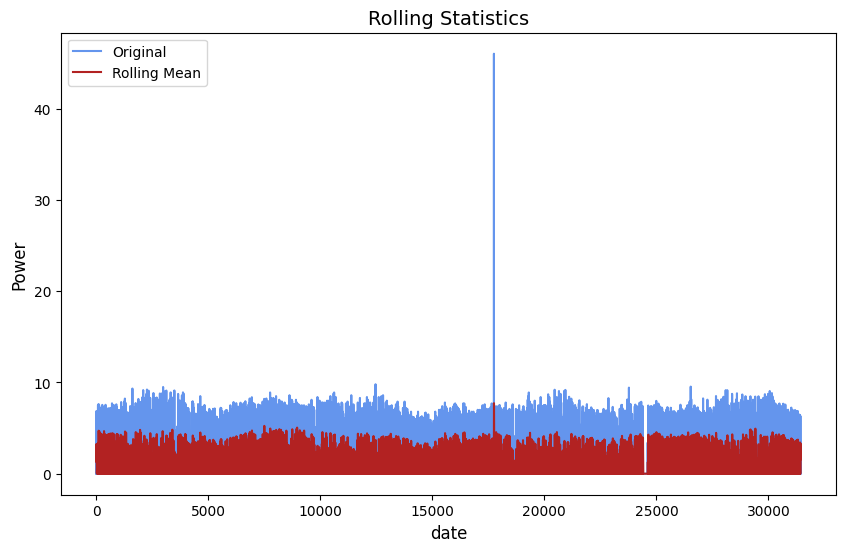

In [55]:
#we can visualise the data now

rolling_mean = df.Power.rolling(window=12).mean()

rolling_std = df.Power.rolling(window=12).std()

plt.figure(figsize = (10,6))
plt.plot(df.Power, color='cornflowerblue', label='Original')

plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')


plt.xlabel('date', size = 12)
plt.ylabel('Power', size  = 12)

plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()





In [56]:
df.rad_all_sky = df.rad_all_sky.mask((df.rad_all_sky.lt(0)).ffill().fillna(0)) #some of the values in the rad_all_sky
#are negative values which are un realistic and the same has been reploaced with 0


In [57]:
df.clearsky_rad = df.clearsky_rad.mask((df.clearsky_rad.lt(0)).ffill().fillna(0))

In [58]:

df

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31440 rows x 9 columns]

<Axes: xlabel='date'>

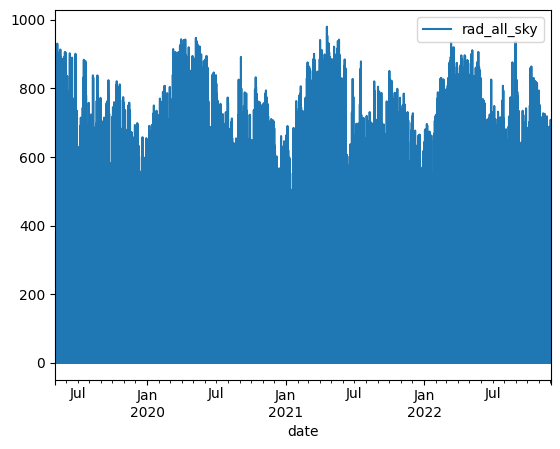

In [59]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

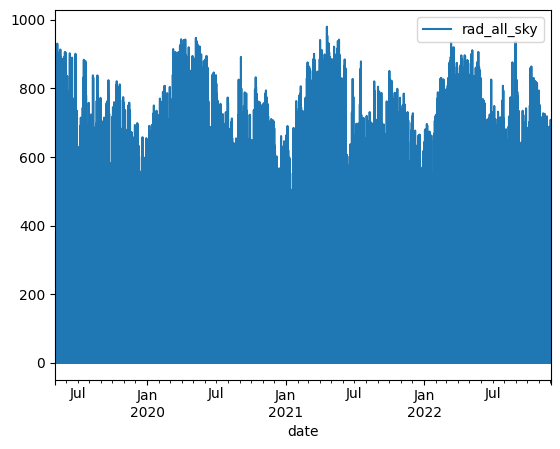

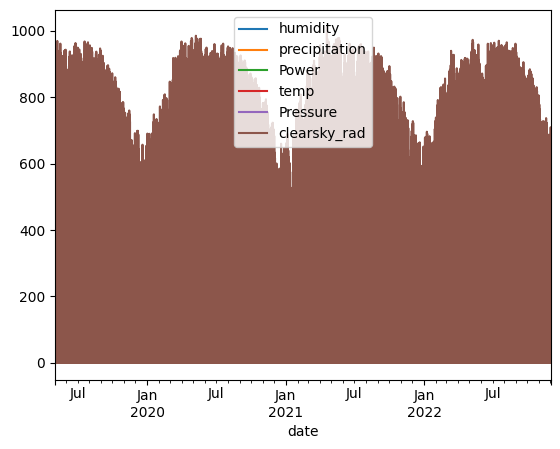

In [60]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

df.plot(x = 'date', y = ['humidity','precipitation','Power','temp','Pressure','clearsky_rad'], kind='line',fig=(12,25))
plt.title
plt.xlabel
plt.ylabel
plt.show()


In [61]:
plt.title


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

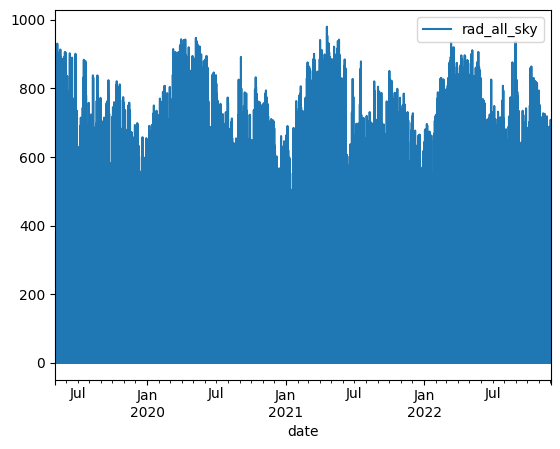

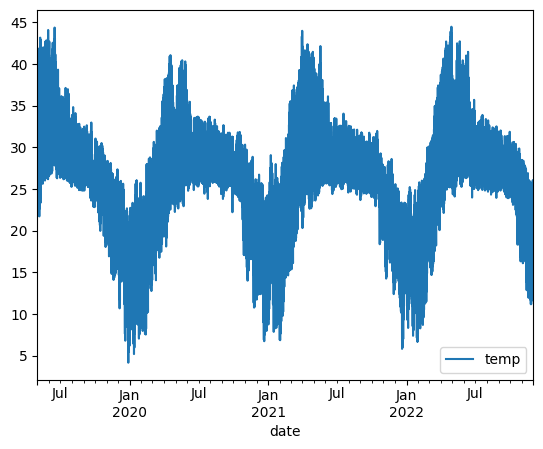

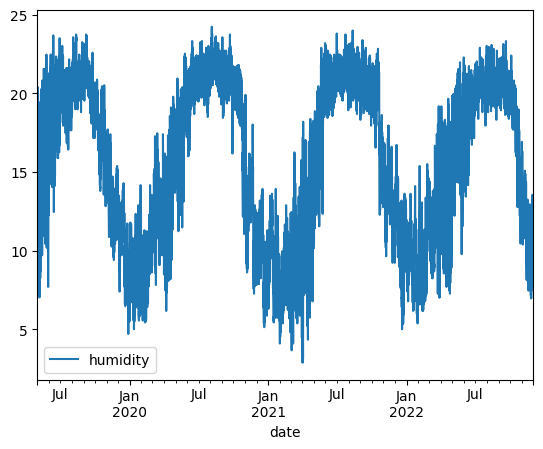

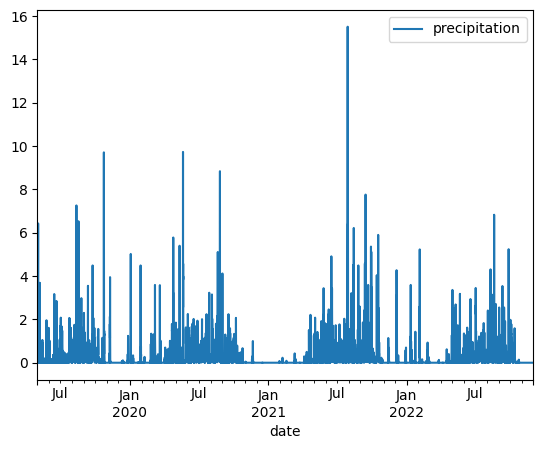

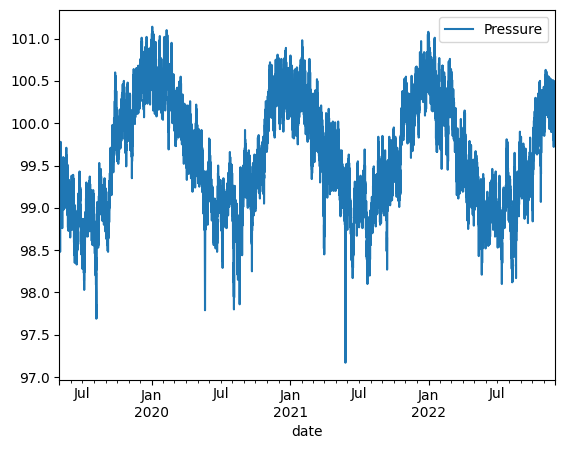

In [62]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

df.plot(x = 'date', y = ['temp'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['humidity'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['precipitation'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['Pressure'], kind='line',fig=(12,25))

plt.title
plt.xlabel
plt.ylabel
plt.show()


In [63]:
#we need to clean the clearsky_rad parameters
df.clearsky_rad = df.clearsky_rad.mask((df.clearsky_rad.lt(0)).ffill().fillna(0))
df.rad_all_sky = df.rad_all_sky.mask((df.rad_all_sky.lt(0)).ffill().fillna(0))
df.dropna(axis=0)

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31416 rows x 9 columns]

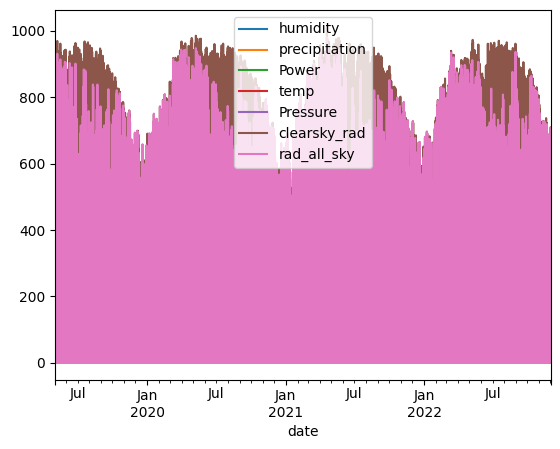

In [64]:
df.plot(x = 'date', y = ['humidity','precipitation','Power','temp','Pressure','clearsky_rad','rad_all_sky'], kind='line',fig=(12,25))
plt.title
plt.xlabel
plt.ylabel
plt.show()

In [65]:
## we can find that there is no negative values against this parameters which  , if present would be unrealistic.


# to save the dataframe as excel file:1
df.to_excel('cleaned_data_for_solar_forecasting.xlsx')

In [66]:
pip install pmdarima

In [67]:
from pmdarima import model_selection

In [68]:
#we need to check the stationality of the time series and here the test resorted is the Augmented Dicky Fuller test
df

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31440 rows x 9 columns]

In [69]:
np.any(~np.isfinite(df.rad_all_sky),axis=0)# checked any of the values are na and the result is that some of the values are na


True

In [70]:
df=df.fillna(0)# we are filling na with 0 values


In [71]:
df

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31440 rows x 9 columns]

In [72]:
np.any(~np.isfinite(df.rad_all_sky),axis=0)

np.any(~np.isfinite(df.rad_all_sky),axis=0)
np.any(~np.isfinite(df.clearsky_rad),axis=0)# no na is there

False

In [73]:
# we have confirmed that this paremeters, i.e rad_all_sky and clearsky_rad does not have any na characters

In [74]:
df.isnull().sum() # reconfirming that there is no na

date             0
temp             0
humidity         0
precipitation    0
rad_all_sky      0
clearsky_rad     0
Pressure         0
wind speed       0
Power            0
dtype: int64

In [75]:
#all the parameters of the point of discussion do not have any 'nas'


In [76]:
df

date   temp  humidity  precipitation  rad_all_sky  \
0     2019-05-02 00:00:00  27.20     18.25            0.0          0.0   
1     2019-05-02 01:00:00  26.74     18.25            0.0          0.0   
2     2019-05-02 02:00:00  26.51     18.31            0.0          0.0   
3     2019-05-02 03:00:00  26.23     18.43            0.0          0.0   
4     2019-05-02 04:00:00  26.09     18.68            0.0          0.0   
...                   ...    ...       ...            ...          ...   
31435 2022-12-01 19:00:00  18.55     10.44            0.0          0.0   
31436 2022-12-01 20:00:00  17.77     10.13            0.0          0.0   
31437 2022-12-01 21:00:00  17.02      9.89            0.0          0.0   
31438 2022-12-01 22:00:00  16.32      9.64            0.0          0.0   
31439 2022-12-01 23:00:00  15.64      9.46            0.0          0.0   

       clearsky_rad  Pressure  wind speed  Power  
0               0.0     99.41        5.50    0.0  
1               0.0     99.34        5.27    0.0  
2               0.0     99.28        5.36    0.0  
3               0.0     99.24        5.54    0.0  
4               0.0     99.23        5.58    0.0  
...             ...       ...         ...    ...  
31435           0.0    100.20        4.08    0.0  
31436           0.0    100.25        4.27    0.0  
31437           0.0    100.26        4.46    0.0  
31438           0.0    100.26        4.69    0.0  
31439           0.0    100.23        5.06    0.0  

[31440 rows x 9 columns]

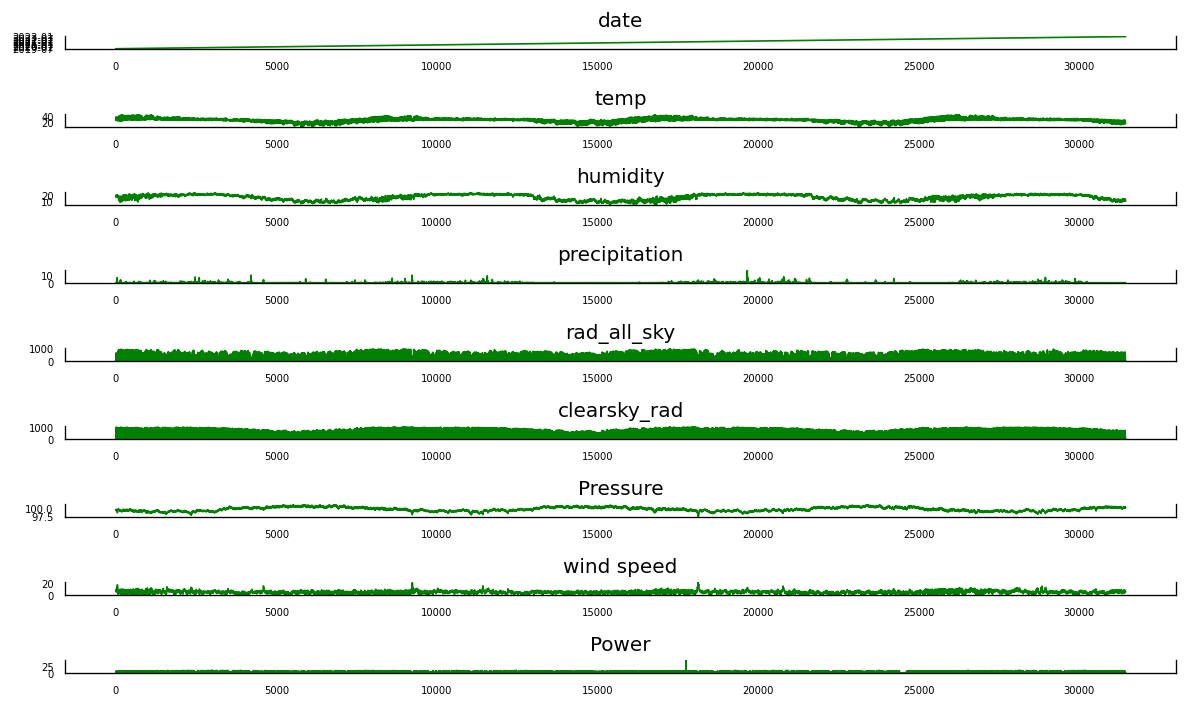

In [77]:

fig, axes = plt.subplots(nrows=9, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):

    data = df[df.columns[i]]
    ax.plot(data, color='green', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


In [78]:
display(df.corr(method='pearson'))

temp  humidity  precipitation  rad_all_sky  clearsky_rad  \
temp           1.000000  0.506259       0.112123     0.514829      0.537697   
humidity       0.506259  1.000000       0.305271    -0.075683      0.036071   
precipitation  0.112123  0.305271       1.000000    -0.040115      0.074610   
rad_all_sky    0.514829 -0.075683      -0.040115     1.000000      0.943507   
clearsky_rad   0.537697  0.036071       0.074610     0.943507      1.000000   
Pressure      -0.653360 -0.758833      -0.290177     0.013814     -0.085037   
wind speed    -0.023702  0.234414       0.234636    -0.261001     -0.181904   
Power          0.423734 -0.110733      -0.058324     0.914932      0.847605   

               Pressure  wind speed     Power  
temp          -0.653360   -0.023702  0.423734  
humidity      -0.758833    0.234414 -0.110733  
precipitation -0.290177    0.234636 -0.058324  
rad_all_sky    0.013814   -0.261001  0.914932  
clearsky_rad  -0.085037   -0.181904  0.847605  
Pressure       1.000000   -0.329536  0.074521  
wind speed    -0.329536    1.000000 -0.264260  
Power          0.074521   -0.264260  1.000000

In [79]:
df1 = df[['date','temp','rad_all_sky','clearsky_rad','Power']] #out of all these parameters we are selecting only 4 parameters which are correlated strongly with Power as we need to forecast power eventually
print(df1.shape)

(31440, 5)


In [80]:
ad_fuller_result_1 = adfuller(df['temp'])
print('realtemp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['humidity'])
print('realhumidity')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df['rad_all_sky'])
print('realrad_all_sky')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df['clearsky_rad'])
print('realclearsky_rad')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')


ad_fuller_result_6 = adfuller(df['Pressure'])
print('realPressure')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

print('\n---------------------\n')

ad_fuller_result_7 = adfuller(df['wind speed'])
print('realwind speed')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

print('\n---------------------\n')

ad_fuller_result_8 = adfuller(df['Power'])
print('realPower')
print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')


realtemp
ADF Statistic: -3.3387483596662735
p-value: 0.013232807787976041

---------------------

realhumidity
ADF Statistic: -4.087185270817568
p-value: 0.0010168557811828004

---------------------

realprecipitation
ADF Statistic: -22.144248983640068
p-value: 0.0

---------------------

realrad_all_sky
ADF Statistic: -13.058616306605815
p-value: 2.0696970429802367e-24

---------------------

realclearsky_rad
ADF Statistic: -4.542219089828733
p-value: 0.0001648388792683547

---------------------

realPressure
ADF Statistic: -4.961255362721805
p-value: 2.6464053028010625e-05

---------------------

realwind speed
ADF Statistic: -16.173525904718186
p-value: 4.339853928033125e-29

---------------------

realPower
ADF Statistic: -16.145438664082537
p-value: 4.6285406039385736e-29


In [81]:
#since the features exhibit repitative trends we are sure that the time series is not stationary and we need to make it stationary by performing difference operaton


ad_fuller_result_1 = adfuller(df['temp'].diff()[1:])

print('realtemp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['humidity'].diff()[1:])

print('realhumidity')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'].diff()[1:])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'].diff()[1:])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')


ad_fuller_result_4 = adfuller(df['rad_all_sky'].diff()[1:])
print('realrad_all_sky')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df['clearsky_rad'].diff()[1:])
print('realclearsky_rad')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(df['Pressure'].diff()[1:])
print('realPressure')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')


print('\n---------------------\n')


ad_fuller_result_7 = adfuller(df['wind speed'].diff()[1:])
print('realwind speed')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

print('\n---------------------\n')


ad_fuller_result_8 = adfuller(df['Power'].diff()[1:])
print('realPower')
print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')

realtemp
ADF Statistic: -27.25574938202276
p-value: 0.0

---------------------

realhumidity
ADF Statistic: -27.26416461306295
p-value: 0.0

---------------------

realprecipitation
ADF Statistic: -34.684976637366425
p-value: 0.0

---------------------

realprecipitation
ADF Statistic: -34.684976637366425
p-value: 0.0

---------------------

realrad_all_sky
ADF Statistic: -36.81090305738591
p-value: 0.0

---------------------

realclearsky_rad
ADF Statistic: -34.19068053153579
p-value: 0.0

---------------------

realPressure
ADF Statistic: -26.350986786972197
p-value: 0.0

---------------------

realwind speed
ADF Statistic: -31.784396913667454
p-value: 0.0

---------------------

realPower
ADF Statistic: -38.49977339588133
p-value: 0.0


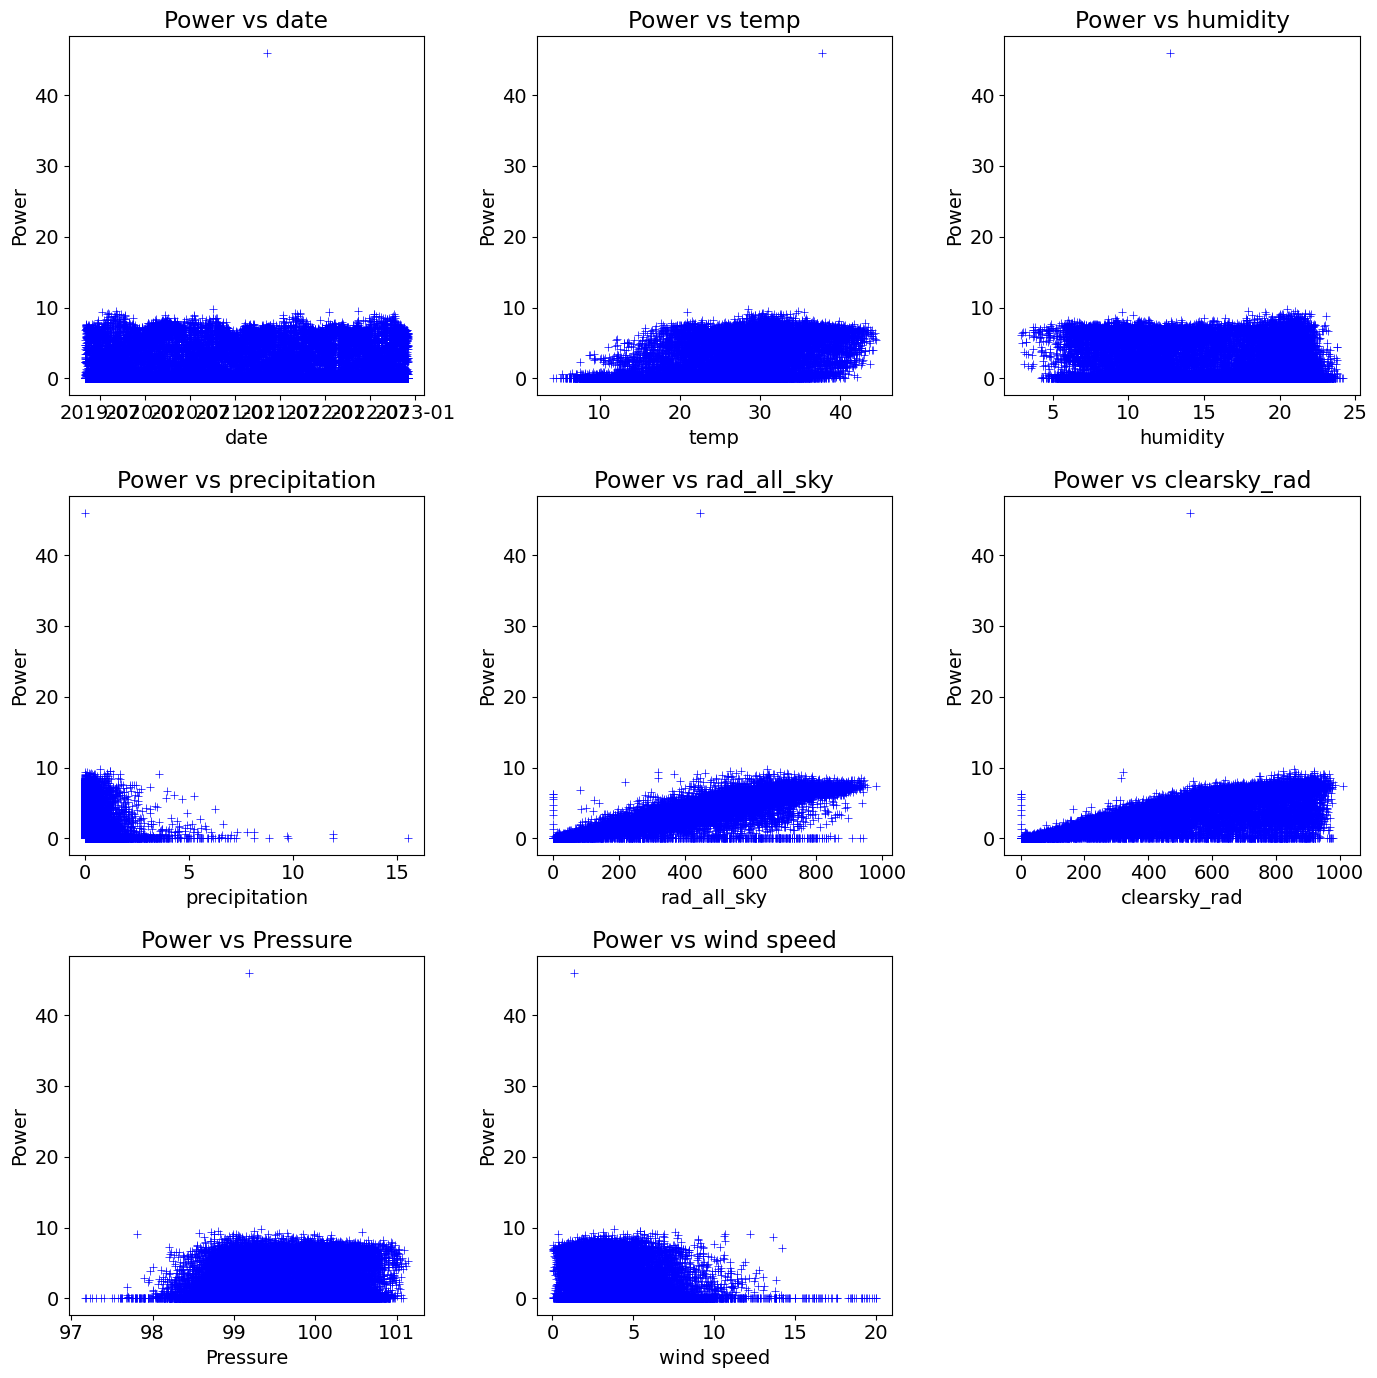

In [82]:
#scatterplot
plt.rcParams["figure.figsize"] = (14, 14)
plt.rcParams["font.size"] = 14

ylabel = 'Power'
columns = ['date','temp', 'humidity', 'precipitation',	'rad_all_sky',	'clearsky_rad',	'Pressure',	'wind speed']

for index, xlabel in enumerate(columns):
  plt.subplot(3, 3, index+1)
  plt.scatter(df[xlabel], df[ylabel],color='blue',marker='+',linewidth=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(ylabel + ' vs ' + xlabel)

plt.tight_layout()

In [83]:
df1 = df[['date','temp','rad_all_sky','clearsky_rad','Power']] #out of all these parameters we are selecting only 4 parameters which are correlated strongly with Power as we need to forecast power eventually
print(df1.shape)

(31440, 5)


In [84]:
df1

date   temp  rad_all_sky  clearsky_rad  Power
0     2019-05-02 00:00:00  27.20          0.0           0.0    0.0
1     2019-05-02 01:00:00  26.74          0.0           0.0    0.0
2     2019-05-02 02:00:00  26.51          0.0           0.0    0.0
3     2019-05-02 03:00:00  26.23          0.0           0.0    0.0
4     2019-05-02 04:00:00  26.09          0.0           0.0    0.0
...                   ...    ...          ...           ...    ...
31435 2022-12-01 19:00:00  18.55          0.0           0.0    0.0
31436 2022-12-01 20:00:00  17.77          0.0           0.0    0.0
31437 2022-12-01 21:00:00  17.02          0.0           0.0    0.0
31438 2022-12-01 22:00:00  16.32          0.0           0.0    0.0
31439 2022-12-01 23:00:00  15.64          0.0           0.0    0.0

[31440 rows x 5 columns]

In [85]:
df1.isna().sum()

date            0
temp            0
rad_all_sky     0
clearsky_rad    0
Power           0
dtype: int64

In [86]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31440 entries, 0 to 31439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          31440 non-null  datetime64[ns]
 1   temp          31440 non-null  float64       
 2   rad_all_sky   31440 non-null  float64       
 3   clearsky_rad  31440 non-null  float64       
 4   Power         31440 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.4 MB


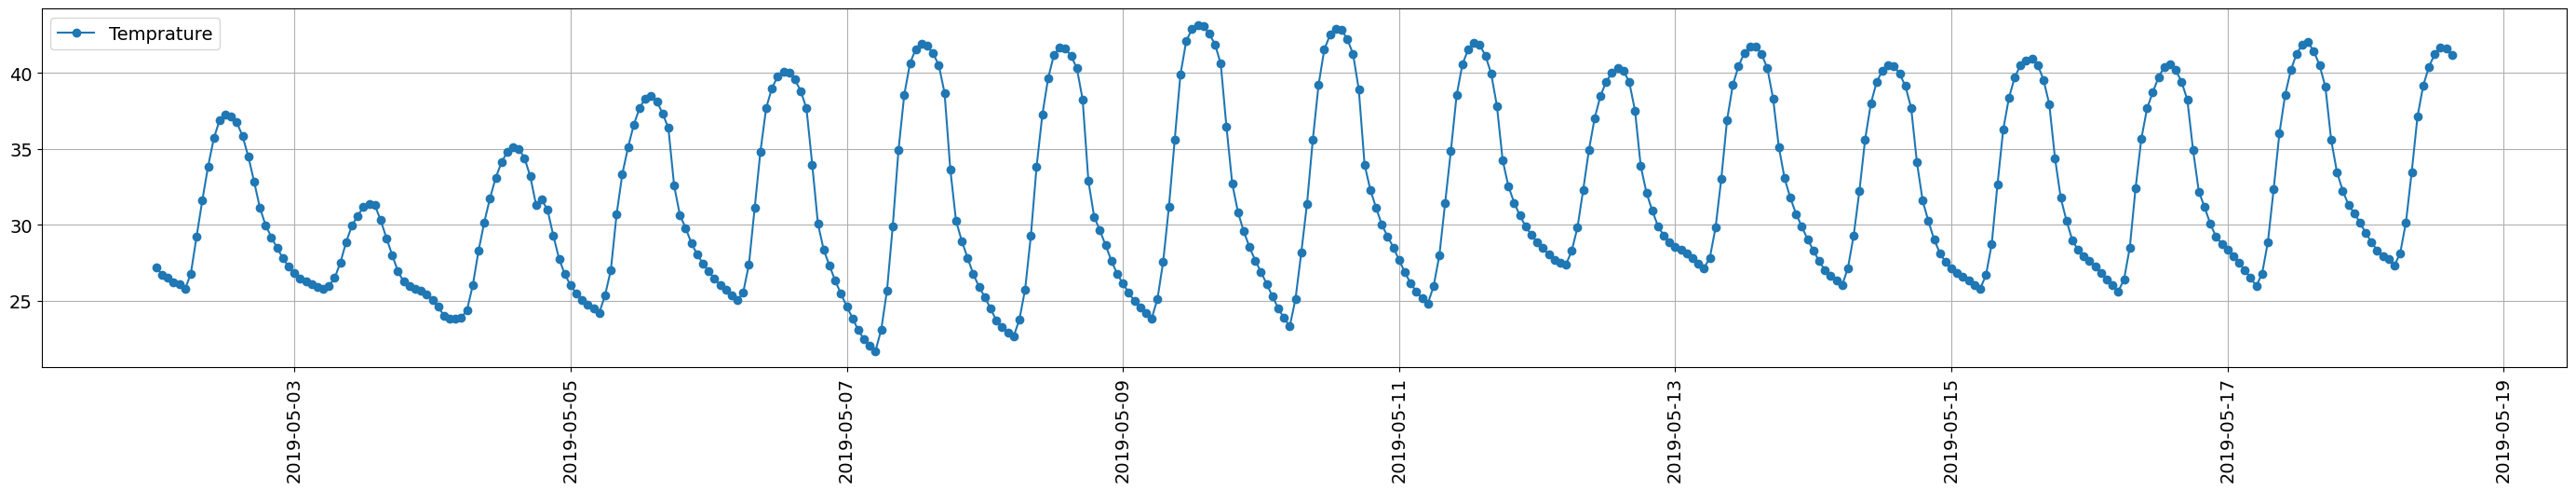

In [87]:

# Plot first 400 observation
# Ploting the curve
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['date'][:400],df1['temp'][:400], marker='o', label='Temprature')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [88]:
#SIMILARLY WE ARE PLOTTING FOR ALL THE VARIABLES LIKE clearsky_rad,rad_all_sky Power

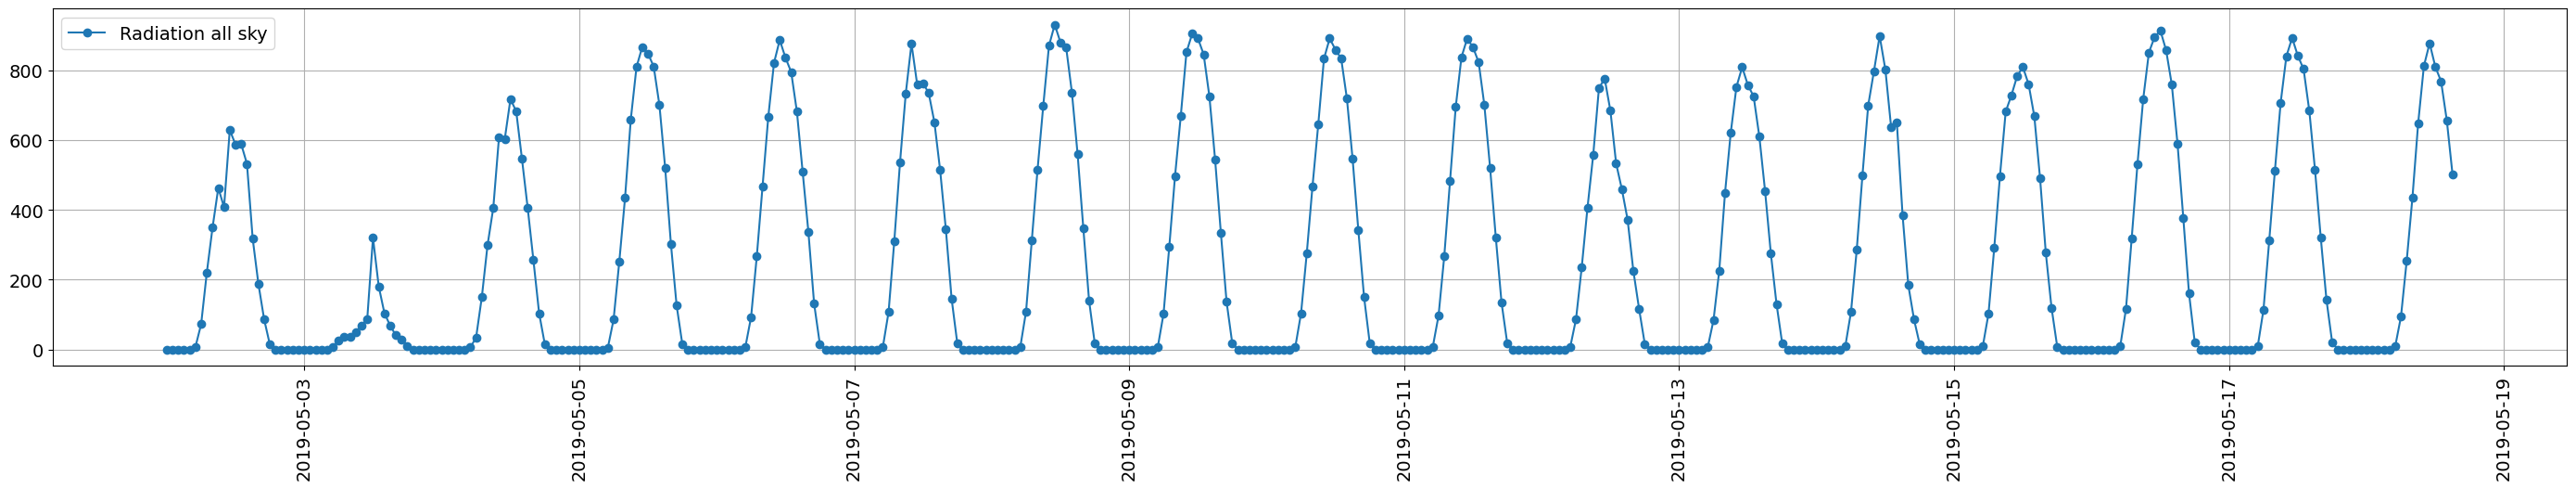

In [89]:

# Plot first 400 observation
# Ploting the curve
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['date'][:400],df1['rad_all_sky'][:400], marker='o', label='Radiation all sky')
plt.xticks(rotation=90)
plt.legend()
plt.show()

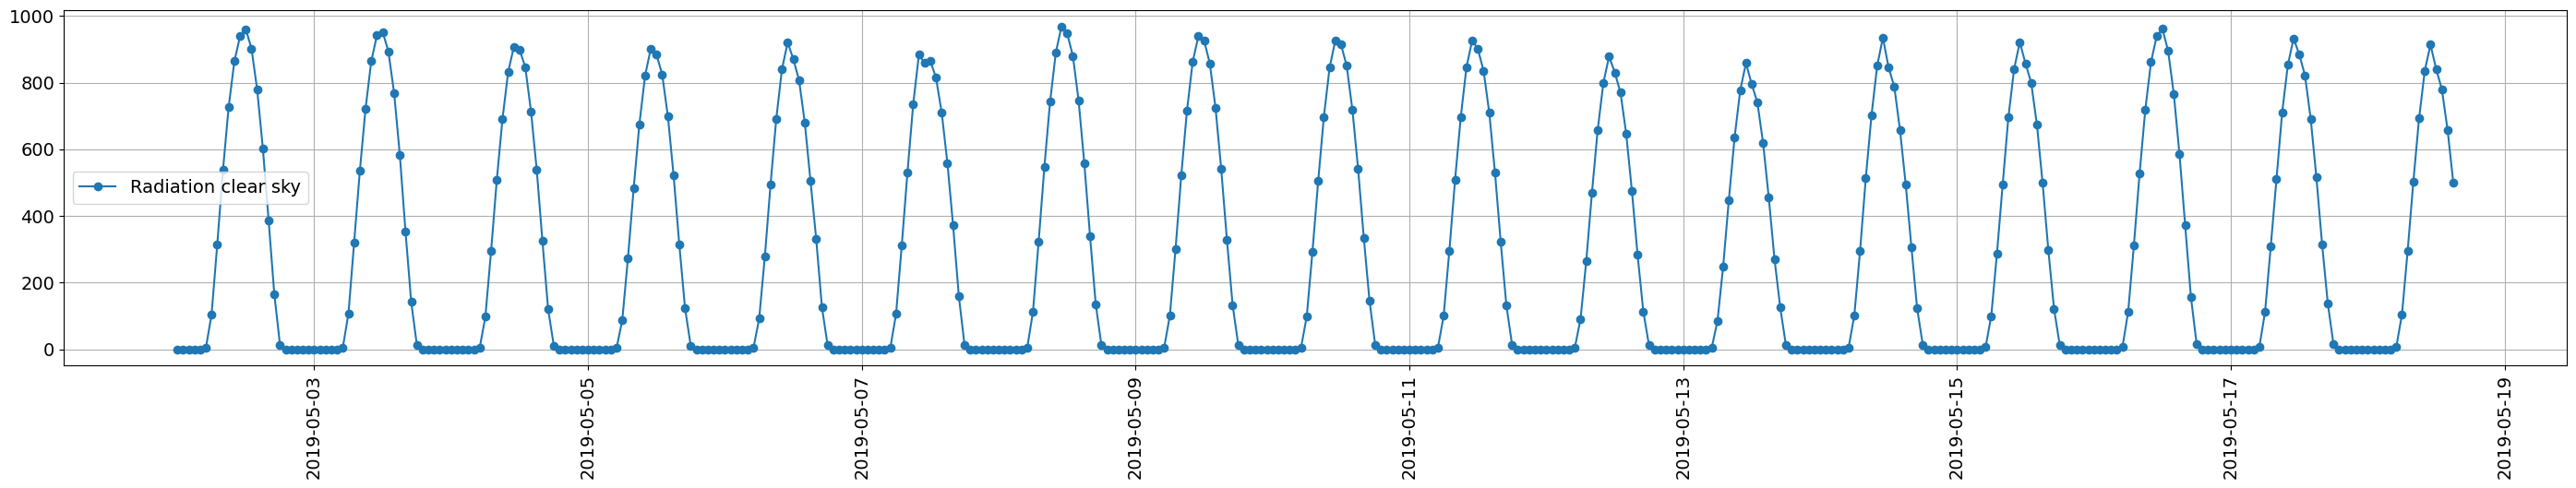

In [90]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['date'][:400],df1['clearsky_rad'][:400], marker='o', label='Radiation clear sky')
plt.xticks(rotation=90)
plt.legend()
plt.show()

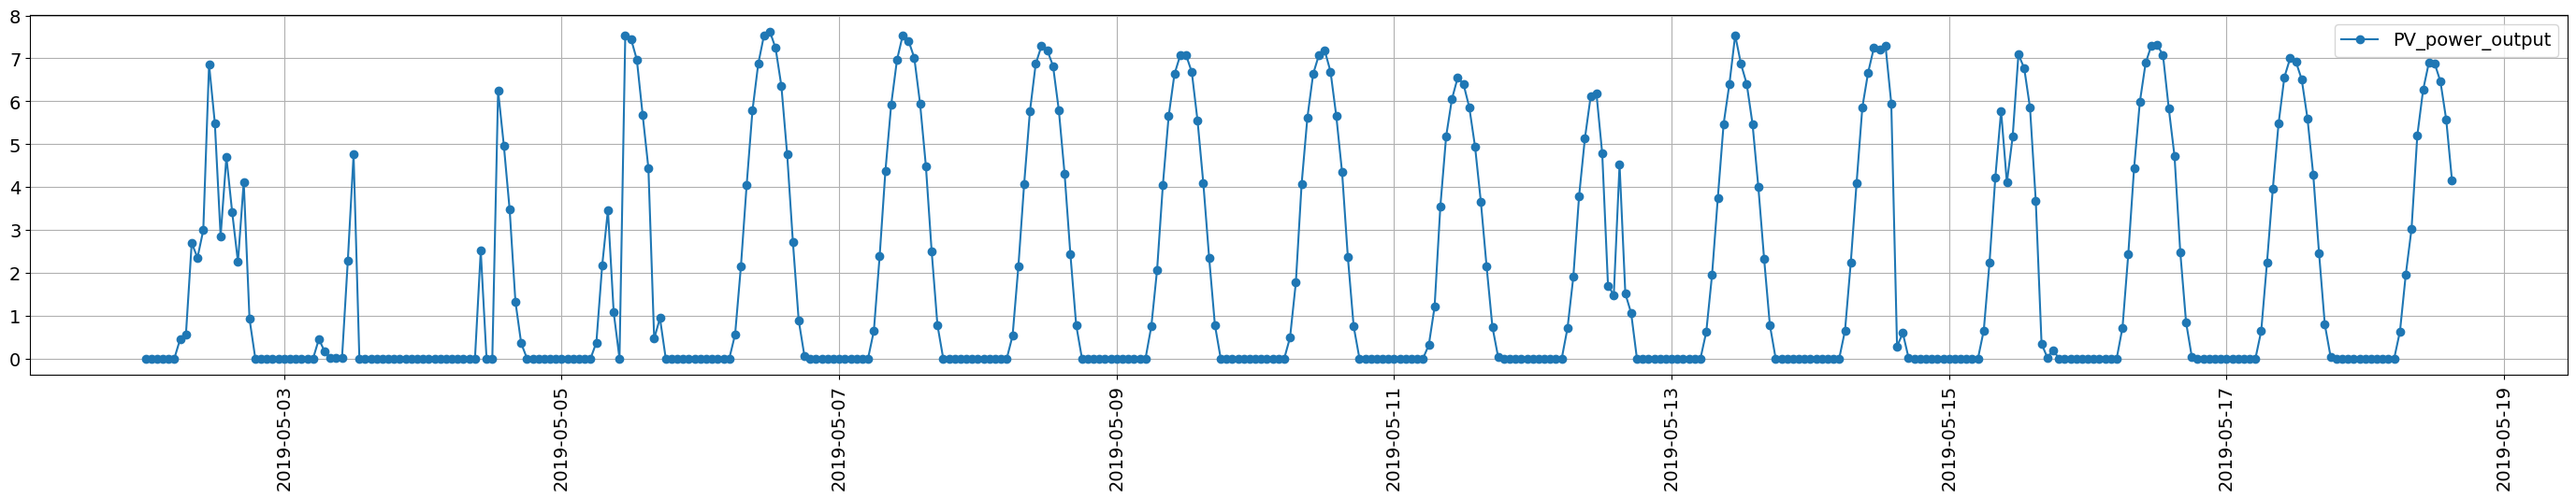

In [91]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['date'][:400],df1['Power'][:400], marker='o', label='PV_power_output')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [92]:
#seasonal decomposition

In [93]:
ts_decomposition = seasonal_decompose(x=df1['temp'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

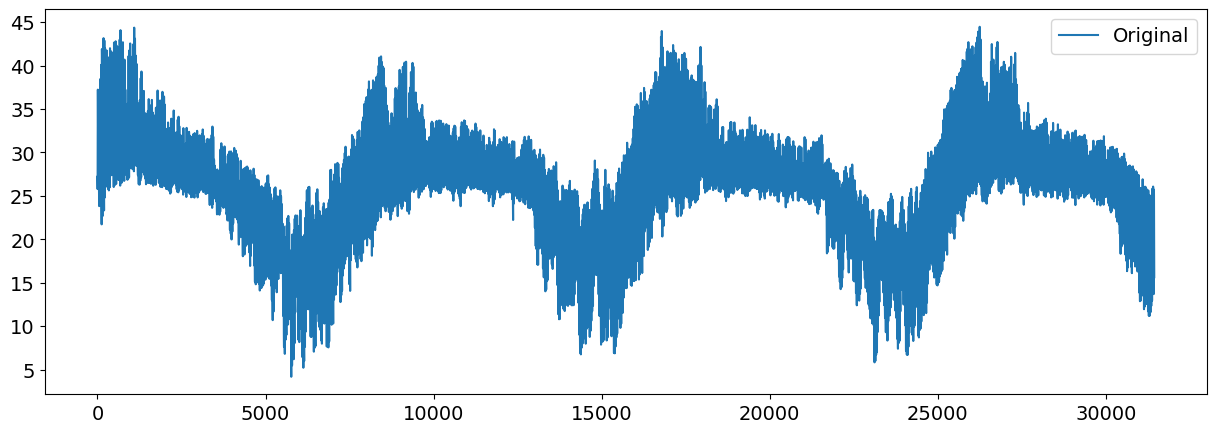

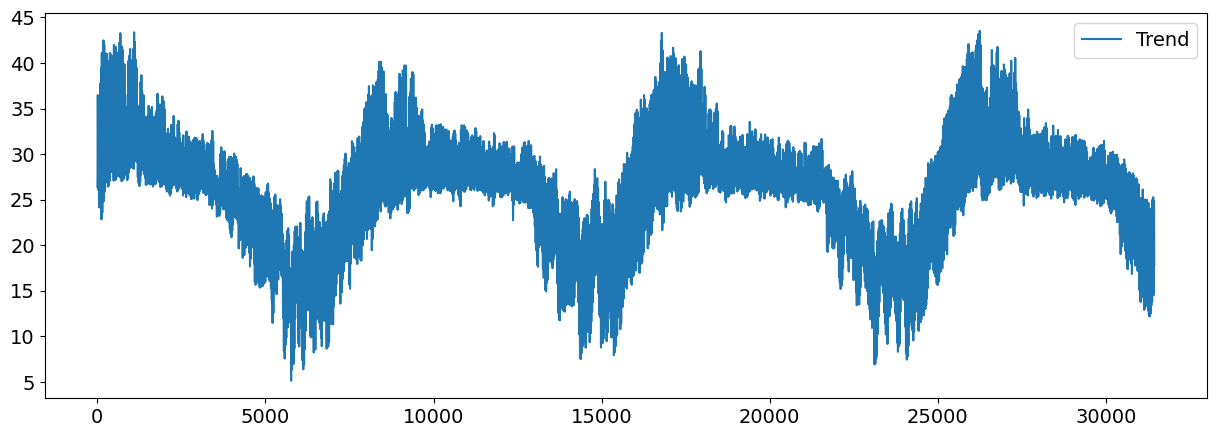

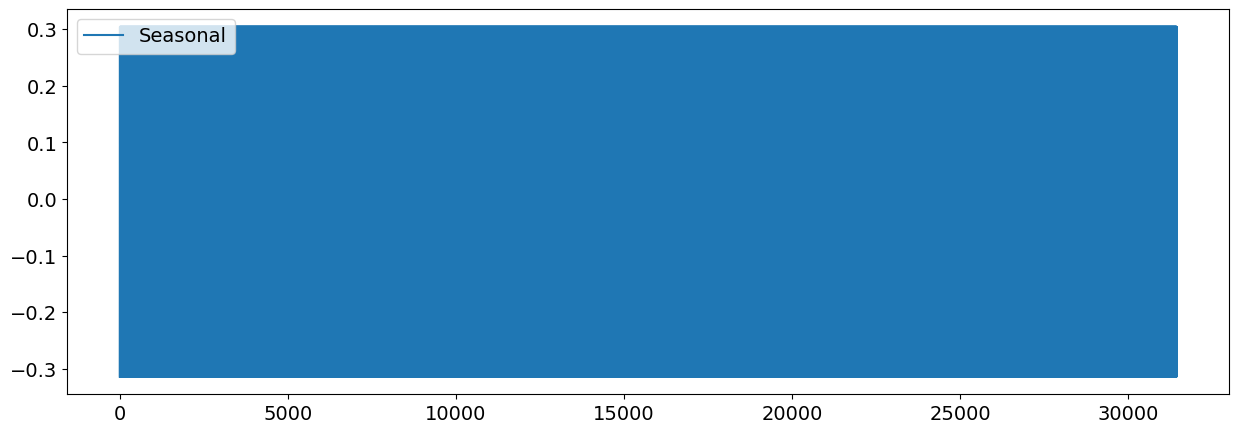

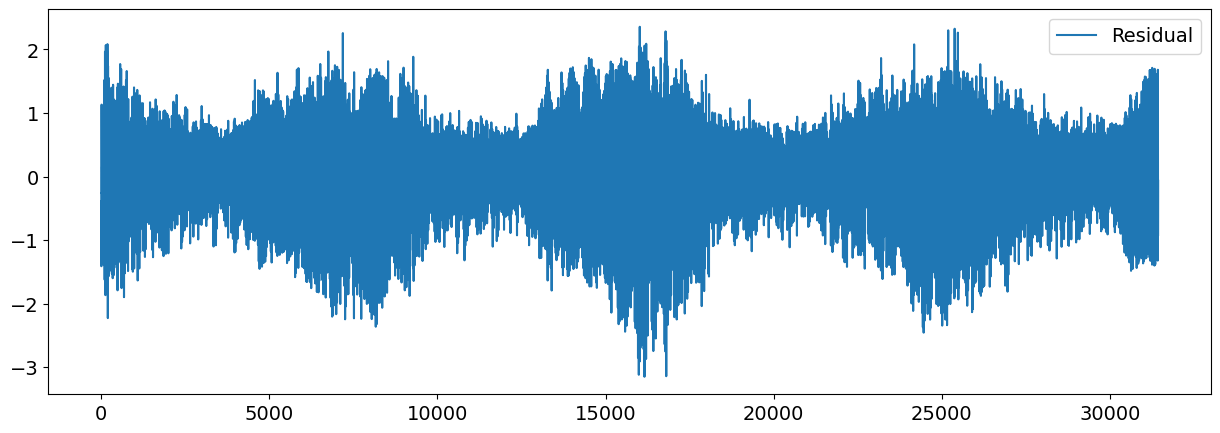

In [94]:
plt.figure(figsize=(15,5))
plt.plot(df1['temp'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

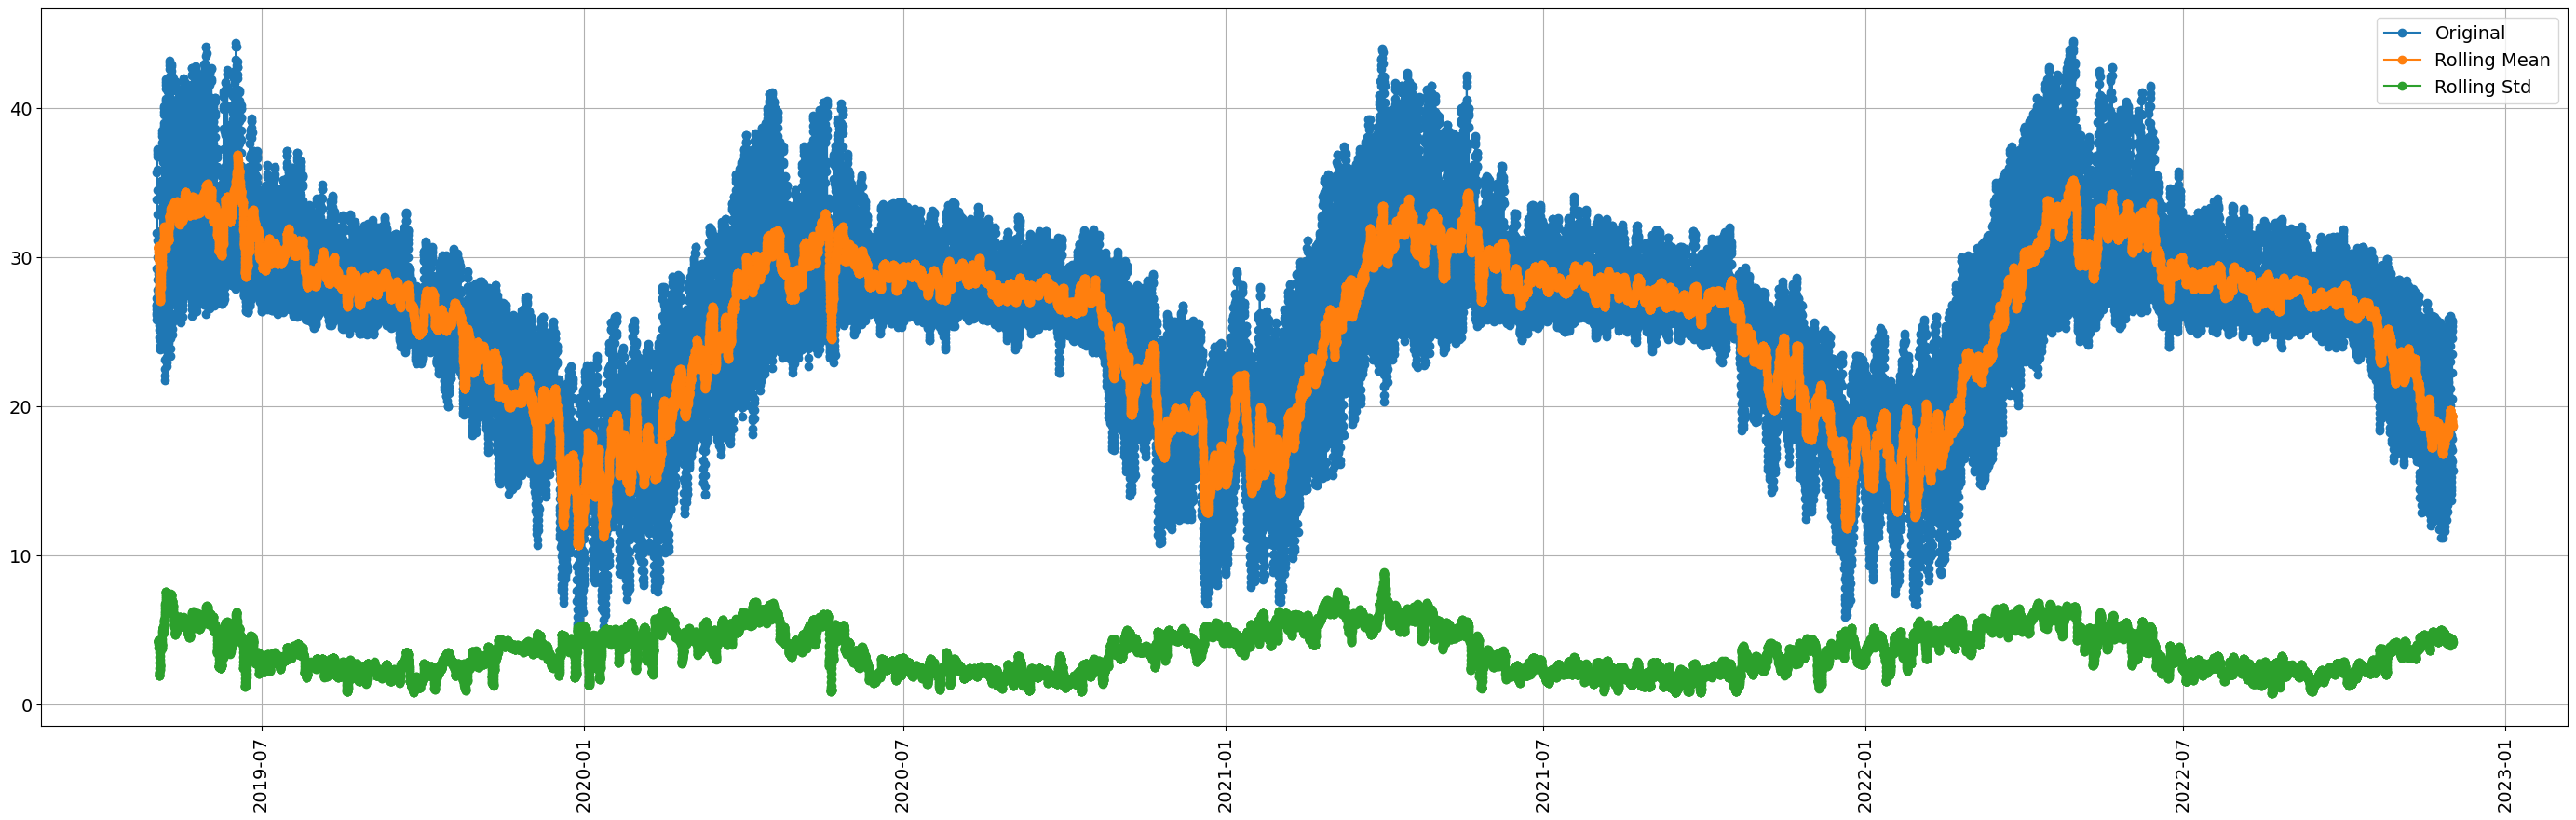

In [95]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df1['date'], df1['temp'], marker='o', label='Original')
plt.plot(df1['date'], df1['temp'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df1['date'], df1['temp'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [96]:
#conclusion:
#mean , standard deviation are not constant
#hence it is not stationary

In [97]:
# for the parameter rad_all_sky

ts_decomposition = seasonal_decompose(x=df1['rad_all_sky'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid







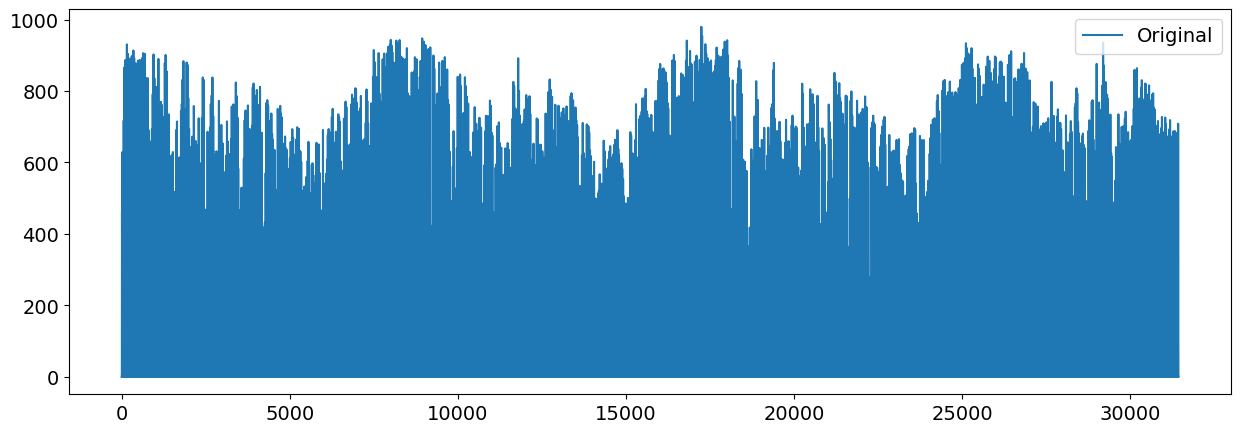

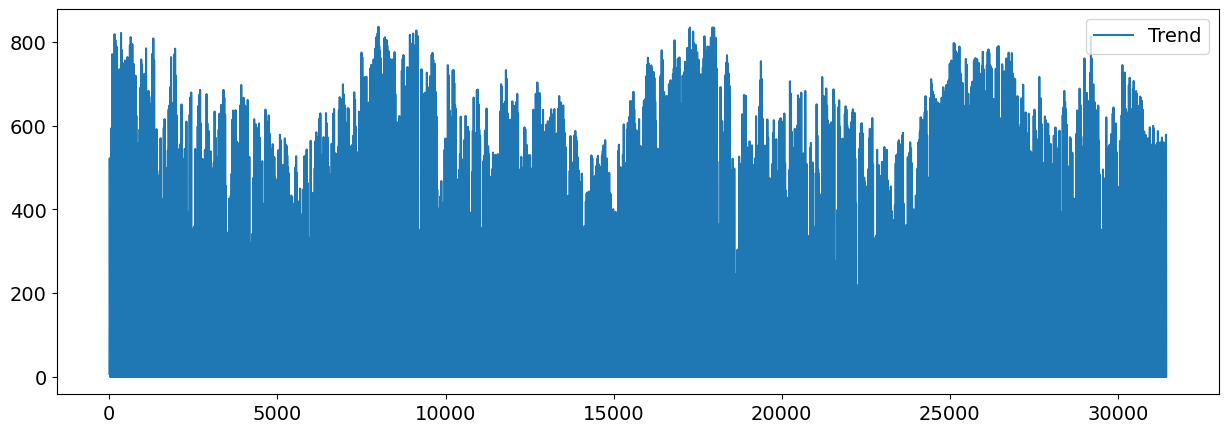

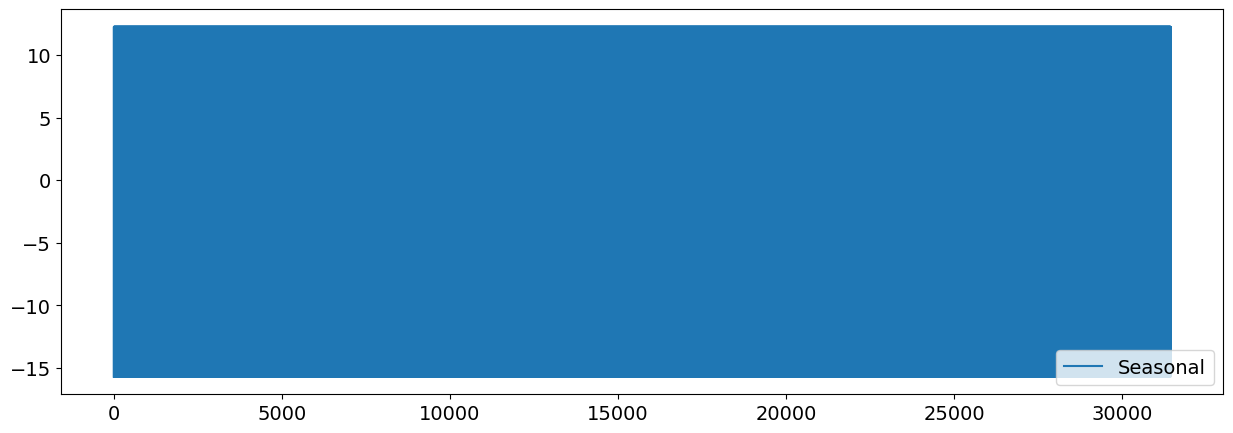

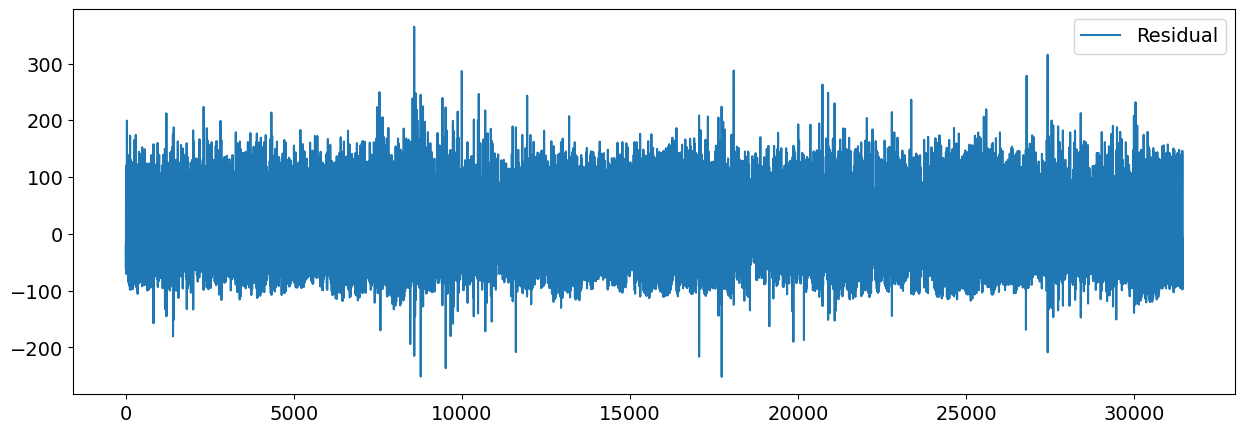

In [98]:
plt.figure(figsize=(15,5))
plt.plot(df1['rad_all_sky'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

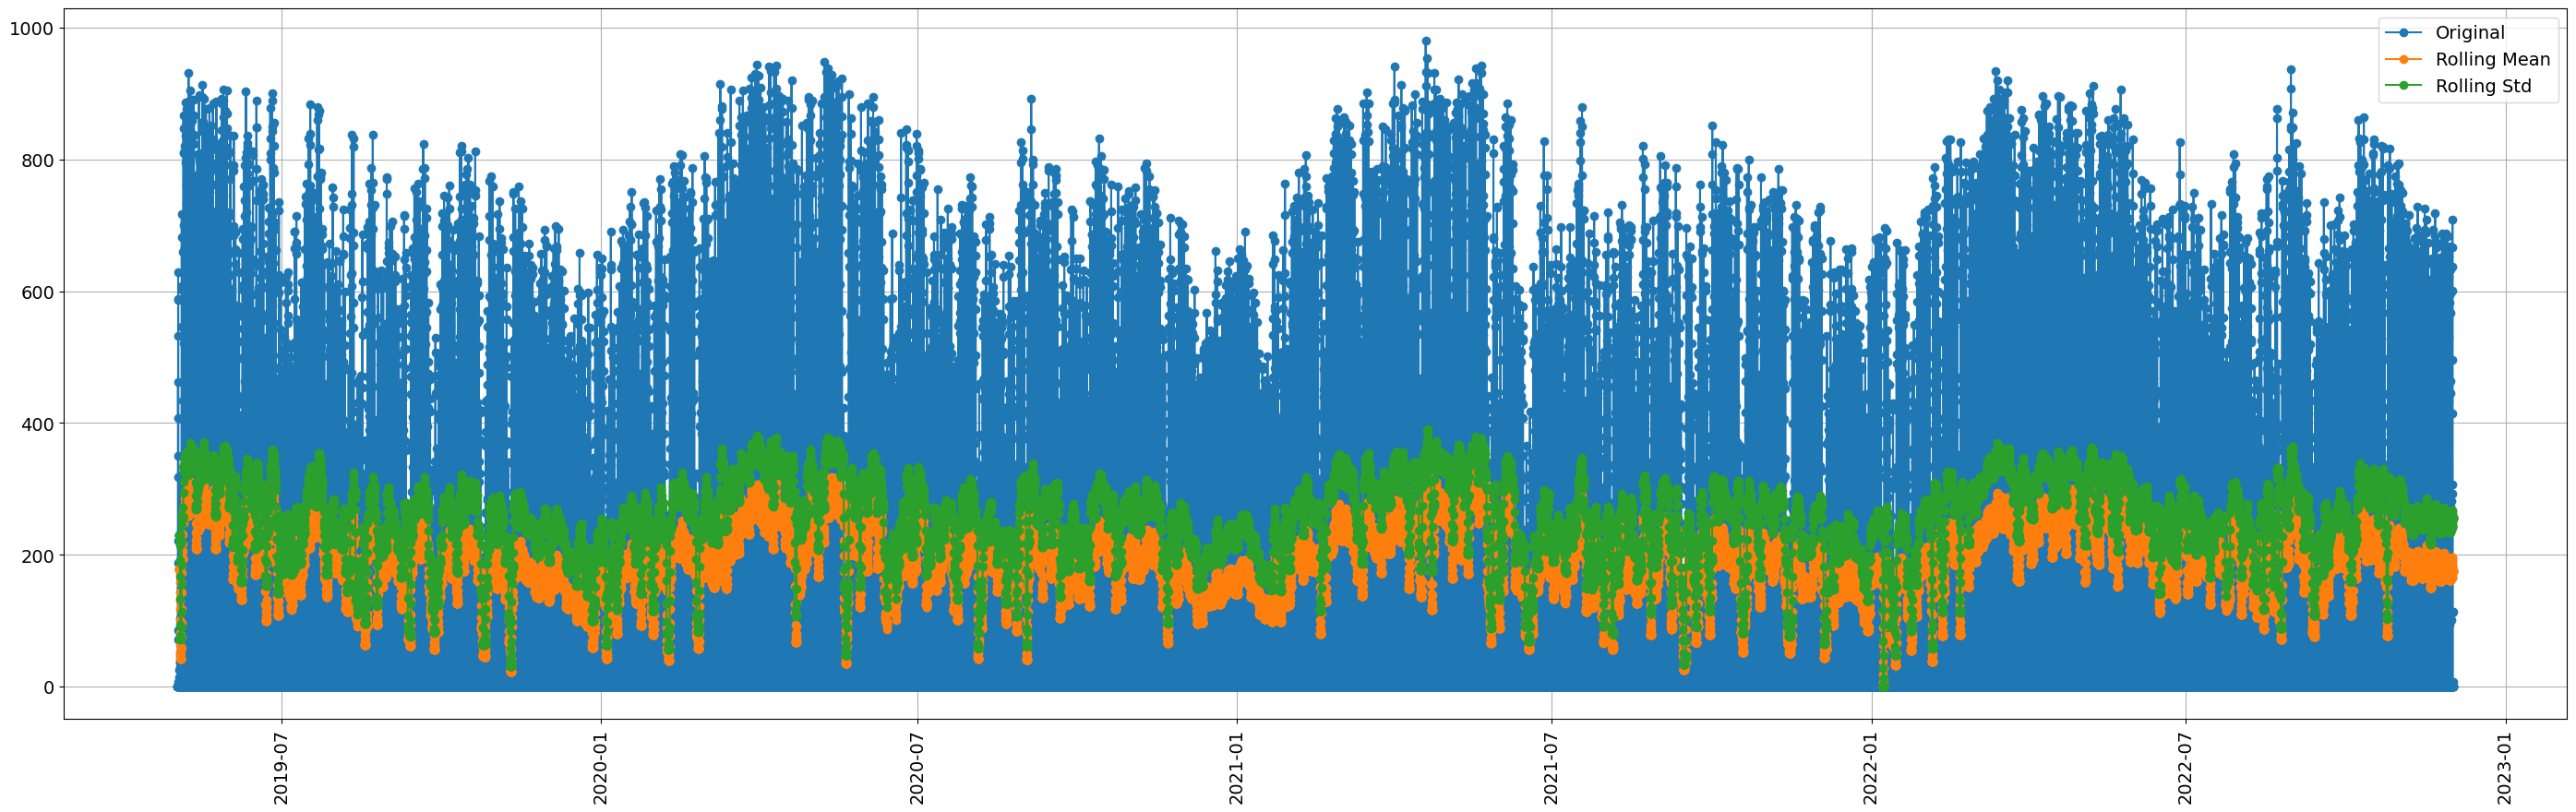

In [99]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df1['date'], df1['rad_all_sky'], marker='o', label='Original')
plt.plot(df1['date'], df1['rad_all_sky'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df1['date'], df1['rad_all_sky'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [100]:
#conclusion:
#mean , standard deviation are not constant
#hence it is not stationary

In [101]:
# for the parameter clearsky_rad

In [102]:
ts_decomposition = seasonal_decompose(x=df1['clearsky_rad'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid


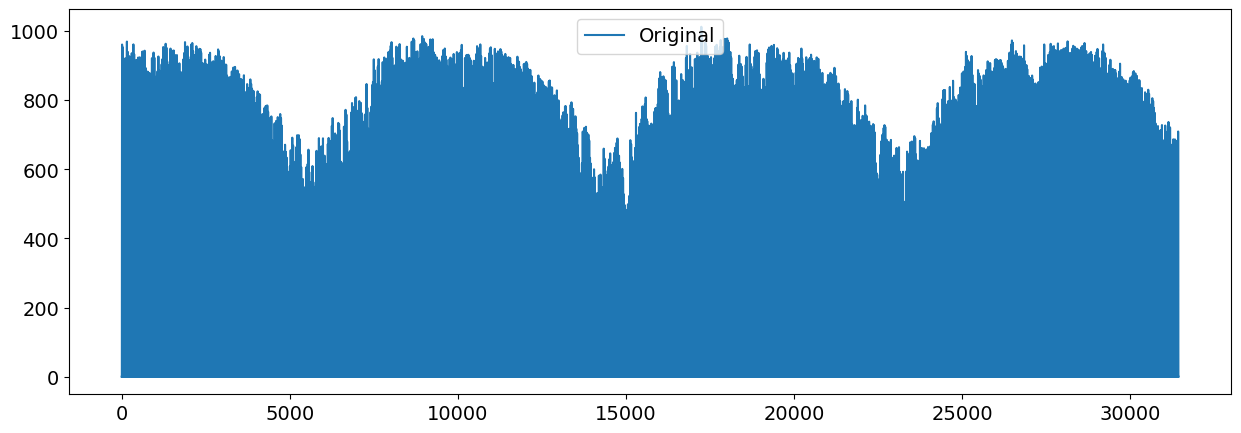

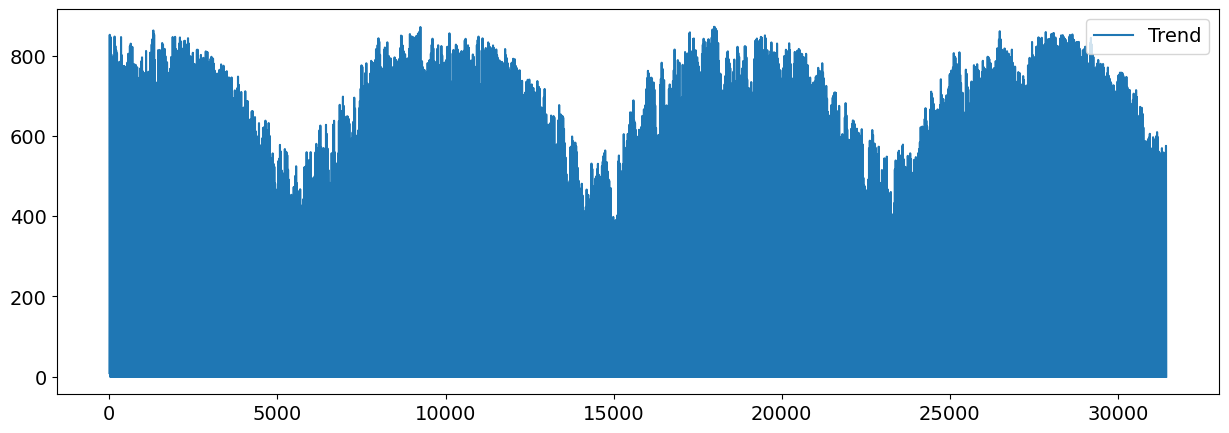

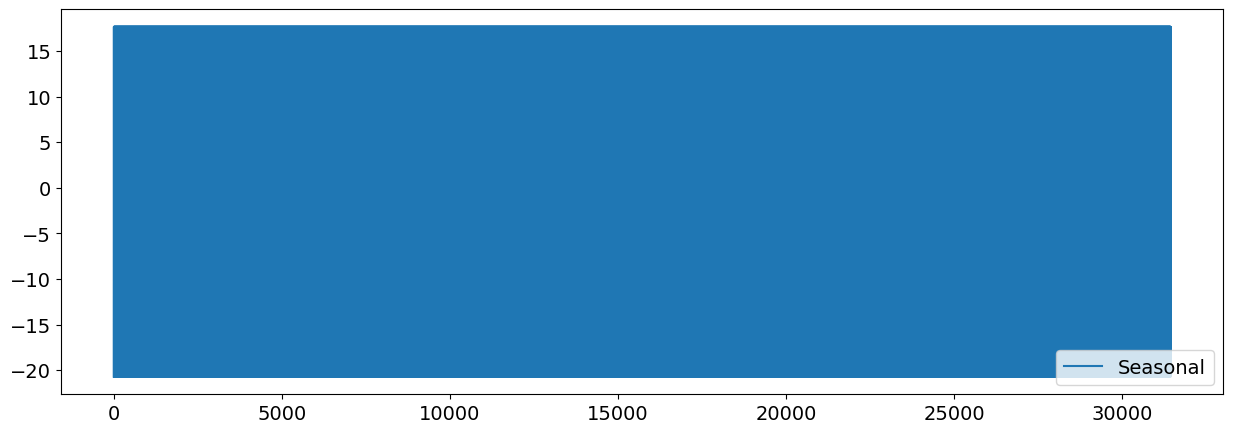

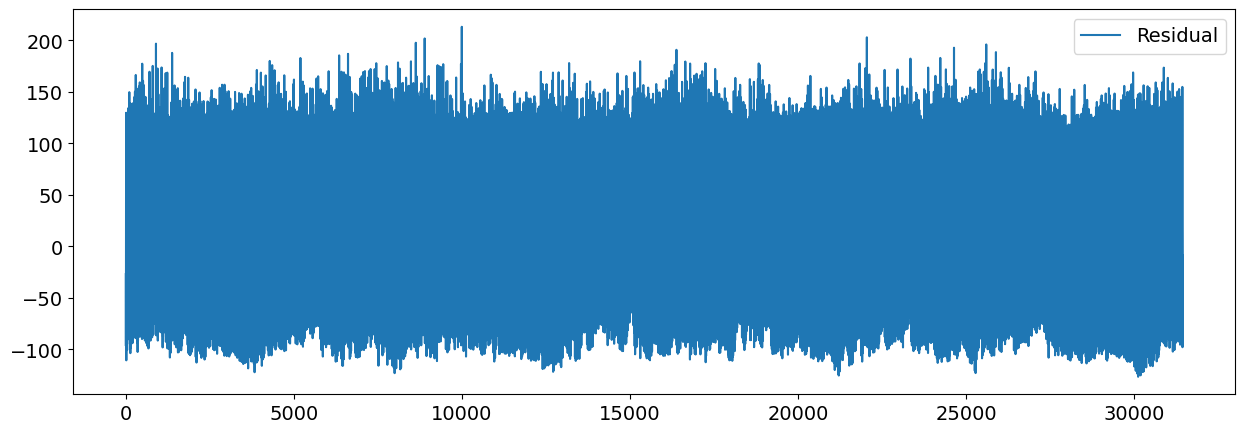

In [103]:
plt.figure(figsize=(15,5))
plt.plot(df1['clearsky_rad'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

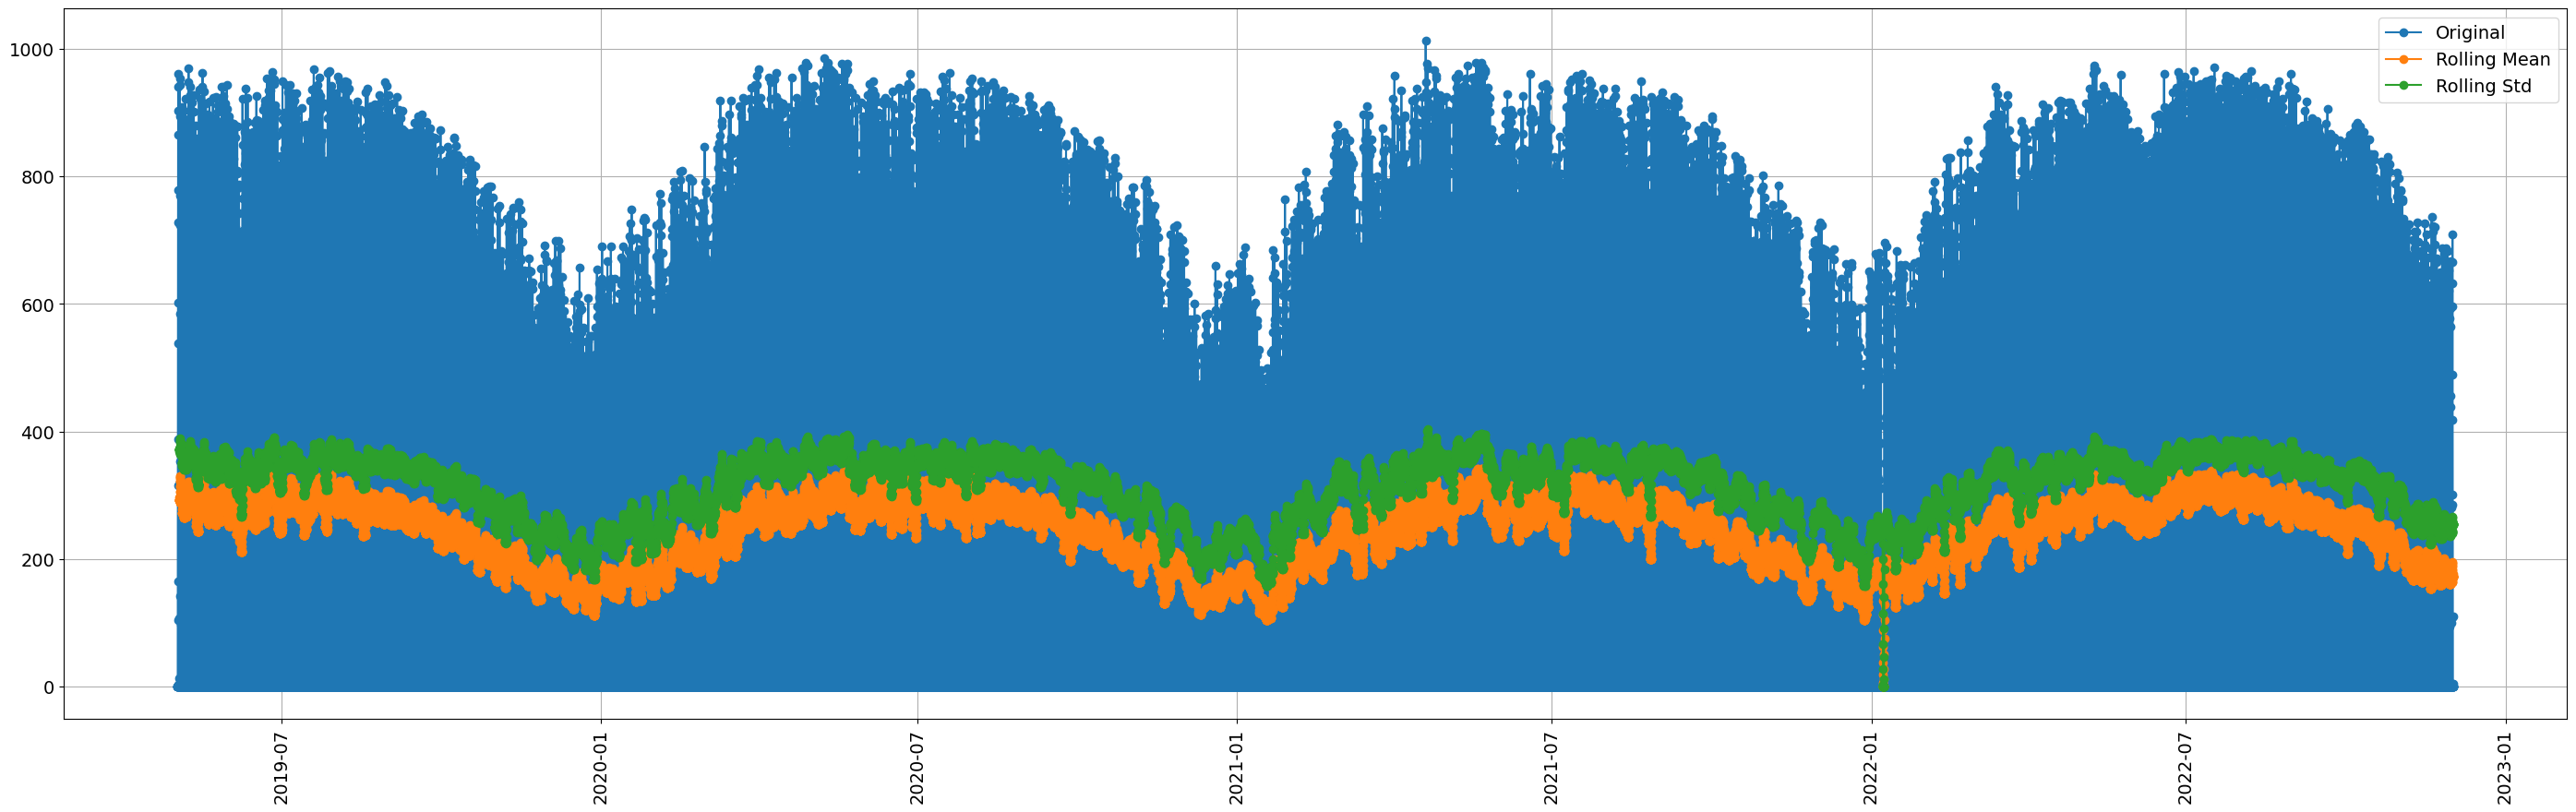

In [104]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df1['date'], df1['clearsky_rad'], marker='o', label='Original')
plt.plot(df1['date'], df1['clearsky_rad'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df1['date'], df1['clearsky_rad'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [105]:
#conclusion:
#mean , standard deviation are not constant
#hence it is not stationary

In [106]:
# for the parameter Power
ts_decomposition = seasonal_decompose(x=df1['Power'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

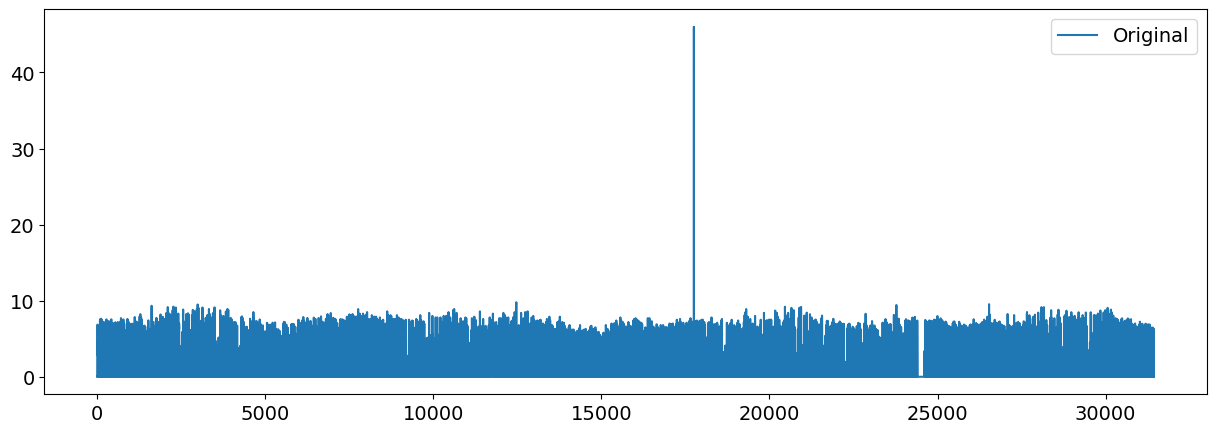

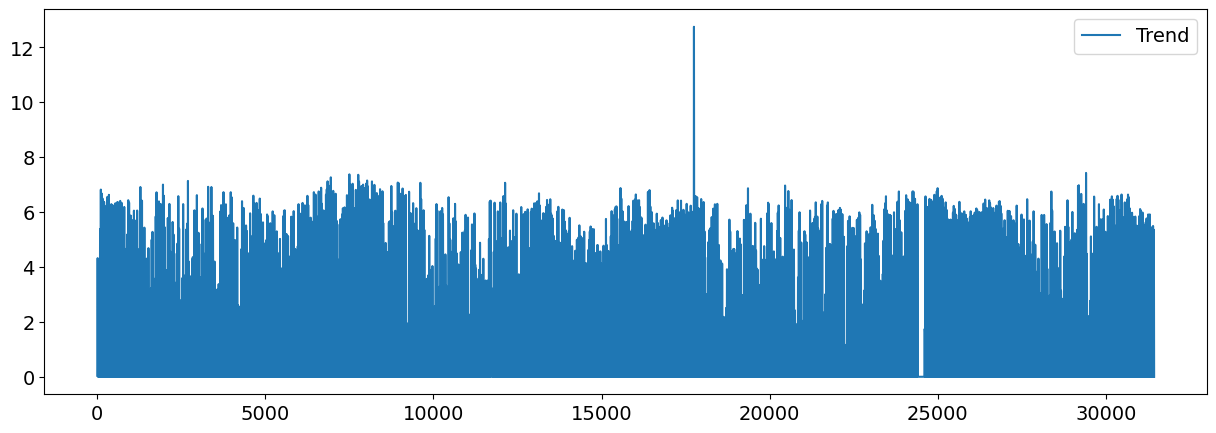

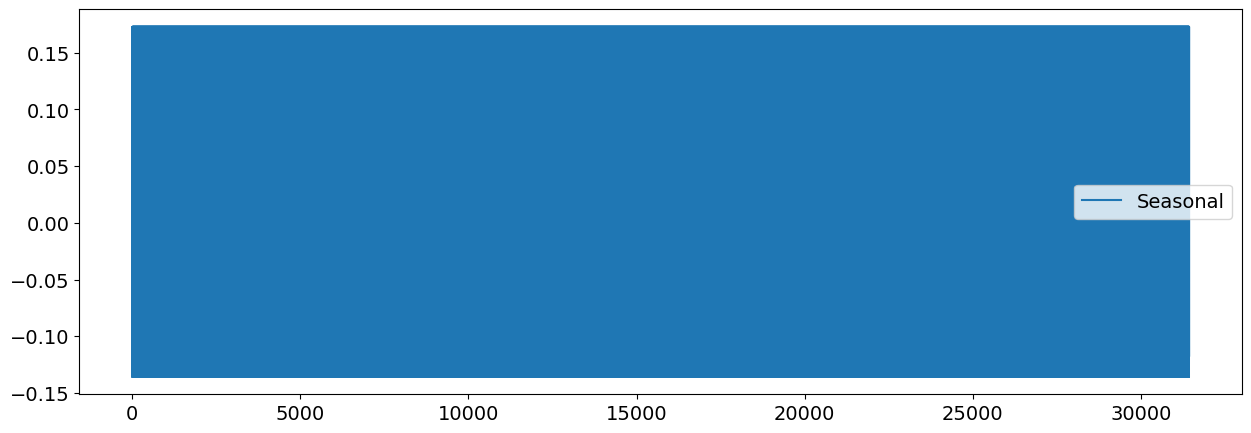

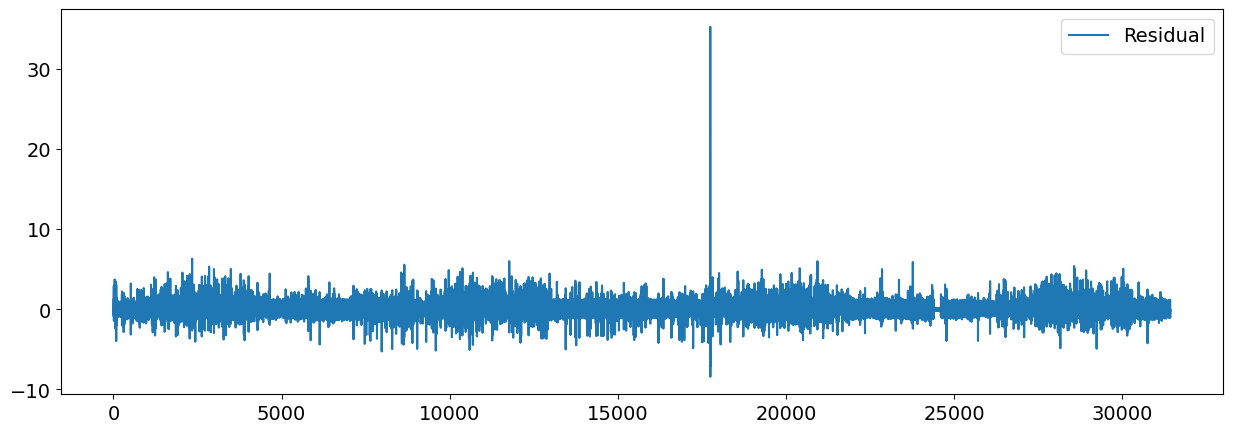

In [107]:
plt.figure(figsize=(15,5))
plt.plot(df1['Power'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

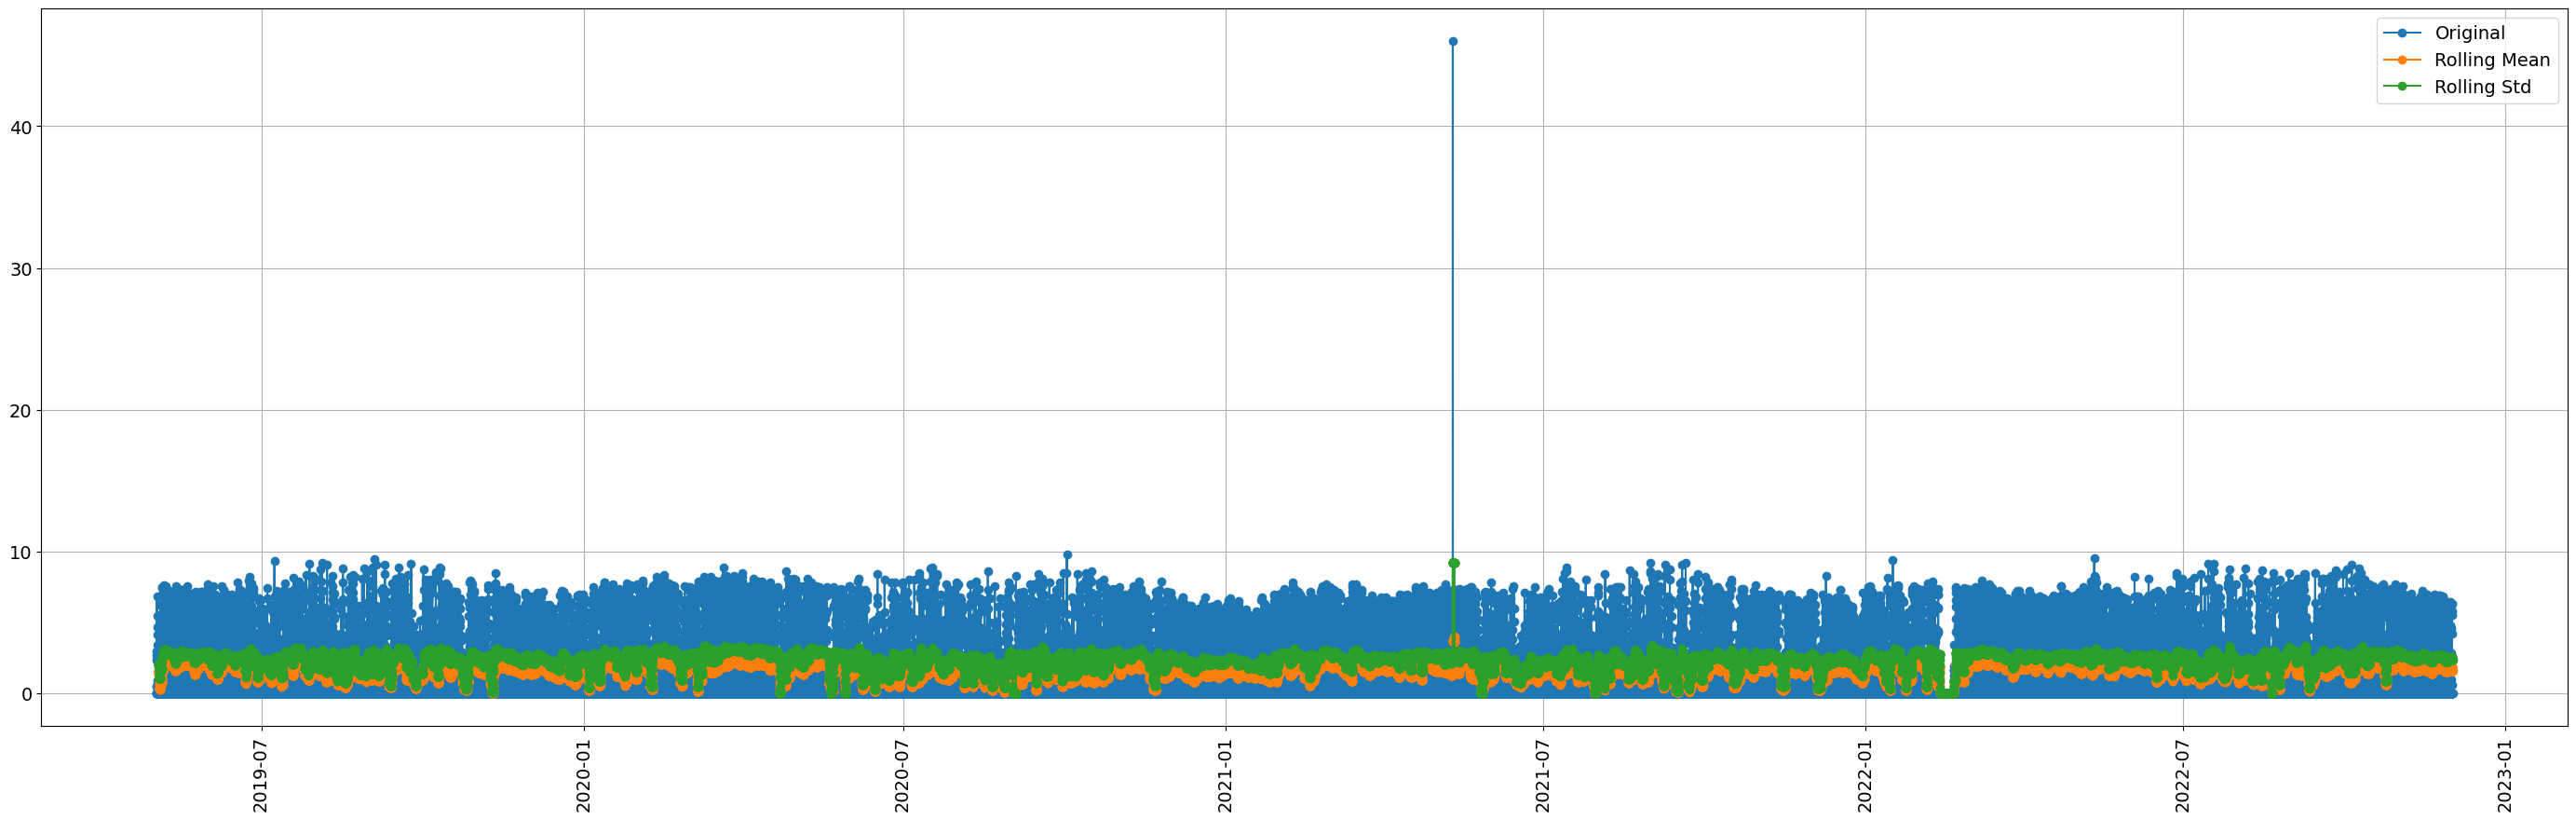

In [108]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df1['date'], df1['Power'], marker='o', label='Original')
plt.plot(df1['date'], df1['Power'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df1['date'], df1['Power'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [109]:
#conclusion:
#mean , standard deviation are not constant
#hence it is not stationary

In [110]:
#for checking stationarity ADF test we need to do

In [111]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [112]:
# ADF Test on each column
for name, column in df1.drop(columns='date').iteritems():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temp" 
    -----------------------------------------------
ADF Statistic: -3.338748
p-value: 0.013233
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "rad_all_sky" 
    -----------------------------------------------
ADF Statistic: -13.058616
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "clearsky_rad" 
    -----------------------------------------------
ADF Statistic: -4.542219
p-value: 0.000165
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "Power" 
    -----------------------------------------------
ADF Statistic: -16.145439
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary




In [113]:
#conclusion:the datas are stationary, so we need not resort to differencing the series

In [114]:
     # now we need to resort to train and test split for all variables

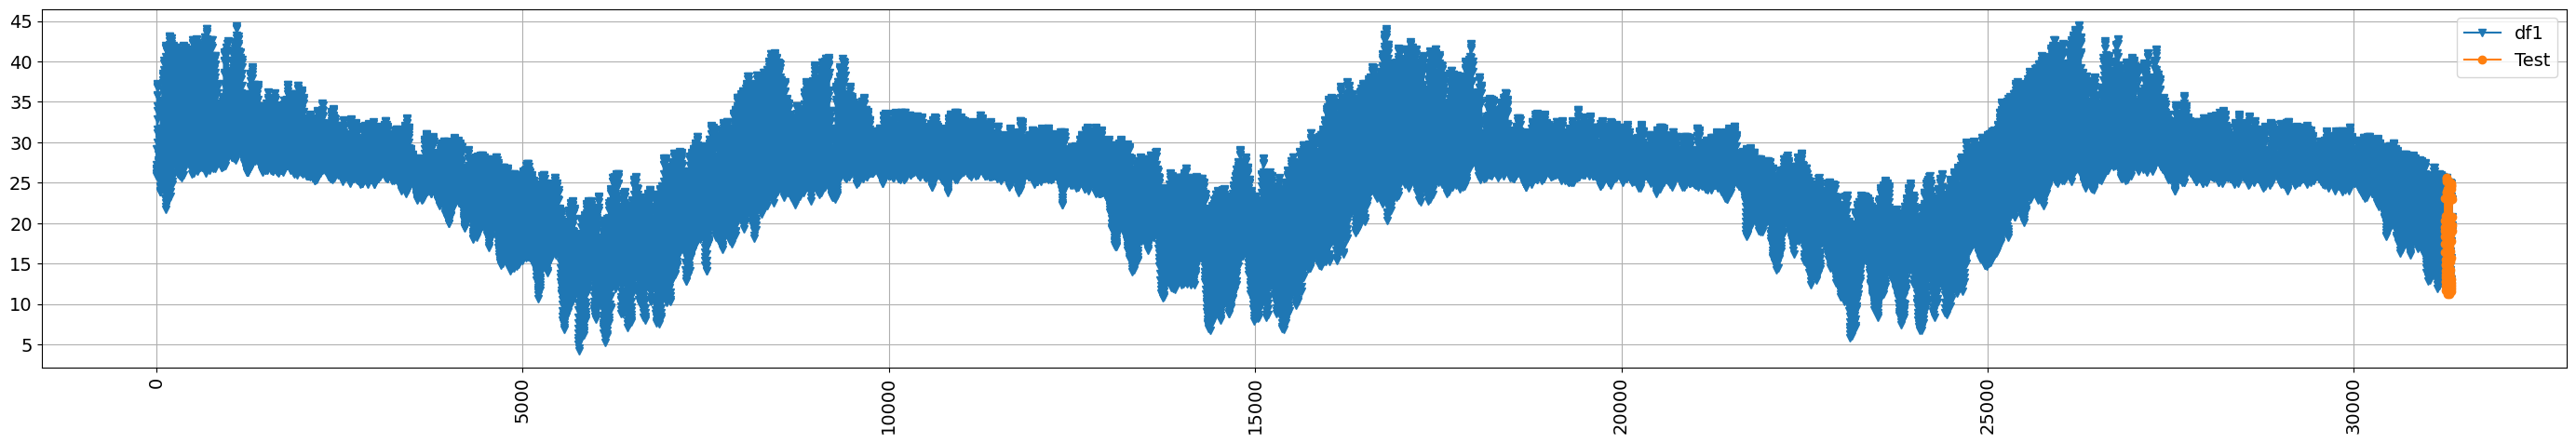

In [115]:

#for temp:
df1=df1[:-100]
test=df1[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['temp'], marker='v', label='df1')
plt.plot( test['temp'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

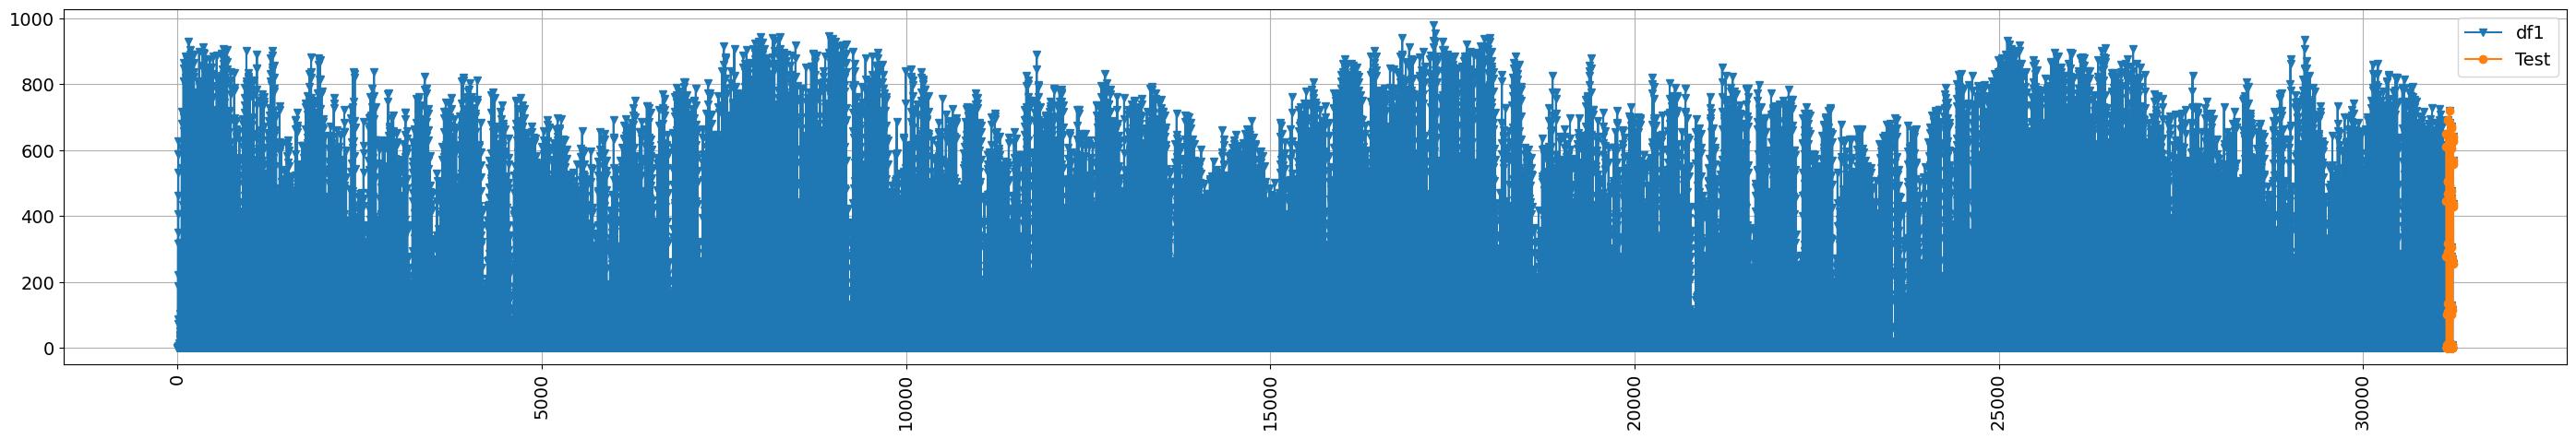

In [116]:

#for rad_all_sky:
df1=df1[:-100]
test=df1[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['rad_all_sky'], marker='v', label='df1')
plt.plot( test['rad_all_sky'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

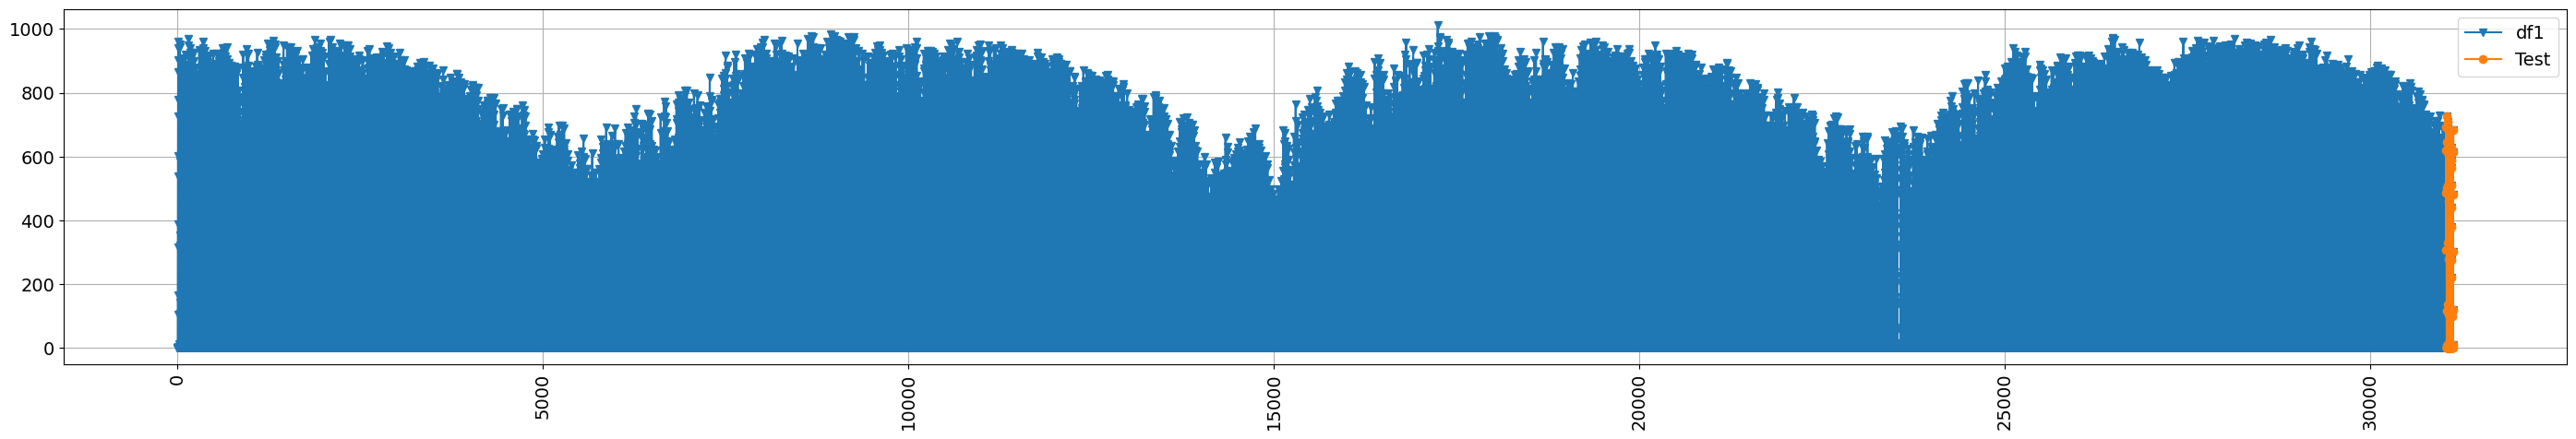

In [117]:
#for clearsky_rad
df1=df1[:-100]
test=df1[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['clearsky_rad'], marker='v', label='df1')
plt.plot( test['clearsky_rad'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

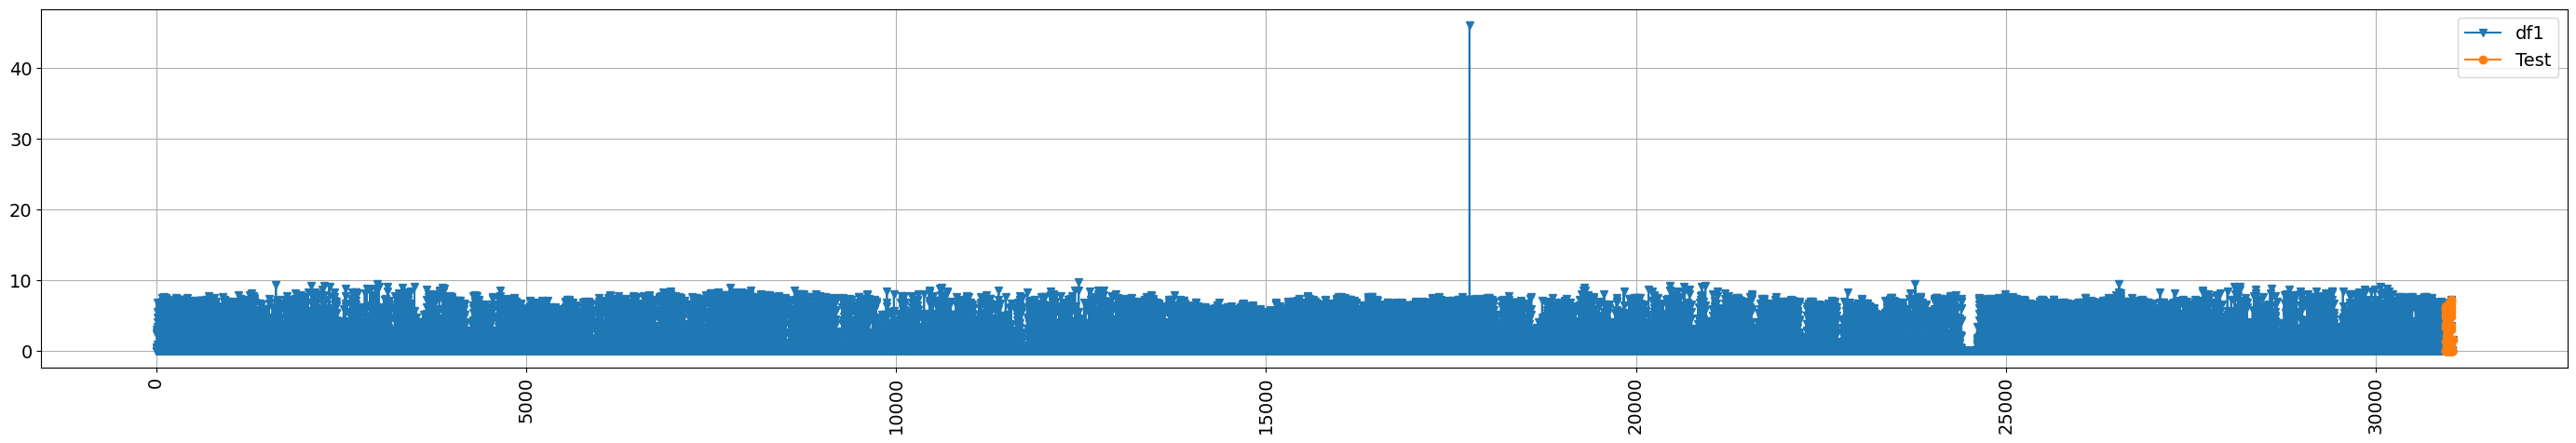

In [118]:
#for Power
df1=df1[:-100]
test=df1[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(df1['Power'], marker='v', label='df1')
plt.plot( test['Power'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [119]:
#Model-Fitting & Model Evaluation
#using Auto-ARIMA with the data set we will compare with test part attribute wise .


In [120]:
#before the same we need to convert the data to index as the auto arima expects the time (here the data column)column as index
df1=df1.set_index('date')

In [121]:
df1

temp  rad_all_sky  clearsky_rad  Power
date                                                        
2019-05-02 00:00:00  27.20         0.00          0.00   0.00
2019-05-02 01:00:00  26.74         0.00          0.00   0.00
2019-05-02 02:00:00  26.51         0.00          0.00   0.00
2019-05-02 03:00:00  26.23         0.00          0.00   0.00
2019-05-02 04:00:00  26.09         0.00          0.00   0.00
...                    ...          ...           ...    ...
2022-11-15 03:00:00  13.91         0.00          0.00   0.00
2022-11-15 04:00:00  13.55         0.00          0.00   0.00
2022-11-15 05:00:00  13.23         0.00          0.00   0.00
2022-11-15 06:00:00  12.94        11.53         11.38   0.00
2022-11-15 07:00:00  14.40       147.27        142.33   1.56

[31040 rows x 4 columns]

In [122]:
df1.resample('M').mean()

temp  rad_all_sky  clearsky_rad     Power
date                                                      
2019-05-31  32.679389   252.917903    280.923750  1.946042
2019-06-30  32.409542   216.138569    271.408139  1.738250
2019-07-31  29.966667   199.178280    283.968280  1.595753
2019-08-31  28.443522   170.288266    277.076411  1.389839
2019-09-30  27.310000   166.392889    257.747264  1.391458
2019-10-31  25.359489   176.682930    217.674731  1.561909
2019-11-30  21.644333   161.072944    176.448181  1.621542
2019-12-31  16.996062   137.032460    148.350242  1.455511
2020-01-31  16.197352   148.302984    166.063992  1.553710
2020-02-29  18.466983   175.054124    195.934914  1.783147
2020-03-31  24.722675   223.783199    240.911089  1.963938
2020-04-30  29.431222   230.511806    269.745403  1.827639
2020-05-31  30.176653   233.157245    284.834355  1.745296
2020-06-30  29.012694   196.880681    280.470847  1.284583
2020-07-31  28.617634   192.144516    284.708468  1.494086
2020-08-31  28.355981   171.959220    278.350995  1.187097
2020-09-30  27.692556   184.713917    254.705611  1.372639
2020-10-31  26.266694   185.140040    224.803401  1.547245
2020-11-30  21.091347   174.285514    185.368556  1.604722
2020-12-31  17.520094   141.455349    144.732325  1.403091
2021-01-31  17.683790   142.158763    149.008992  1.368280
2021-02-28  20.938363   193.757664    203.839673  1.715179
2021-03-31  28.180013   219.249315    226.861210  1.761425
2021-04-30  31.642250   239.419750    264.744000  1.782639
2021-05-31  30.840309   231.556452    285.403226  1.685484
2021-06-30  28.790500   180.280208    271.413403  1.387083
2021-07-31  28.329328   178.877702    281.668253  1.370968
2021-08-31  27.792083   173.238750    271.177648  1.425941
2021-09-30  27.120028   155.348083    259.041528  1.207514
2021-10-31  26.071008   181.757070    216.772218  1.571976
2021-11-30  21.641583   162.621986    180.621875  1.561736
2021-12-31  17.521989   135.171008    156.334234  1.344220
2022-01-31  16.329718   140.334355    159.461263  1.557634
2022-02-28  18.874747   184.409301    205.647009  1.172515
2022-03-31  25.280027   234.600766    241.852487  1.968266
2022-04-30  32.078417   242.229889    256.153972  1.908597
2022-05-31  31.459382   239.085323    277.515995  1.892392
2022-06-30  30.382819   200.109375    276.498875  1.707000
2022-07-31  28.455457   190.931452    300.551882  1.427970
2022-08-31  27.931828   179.880524    285.574798  1.382634
2022-09-30  27.428889   181.540972    259.373625  1.607917
2022-10-31  25.375202   197.253051    232.047379  1.740134
2022-11-30  21.928314   179.805988    184.117151  1.752529

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

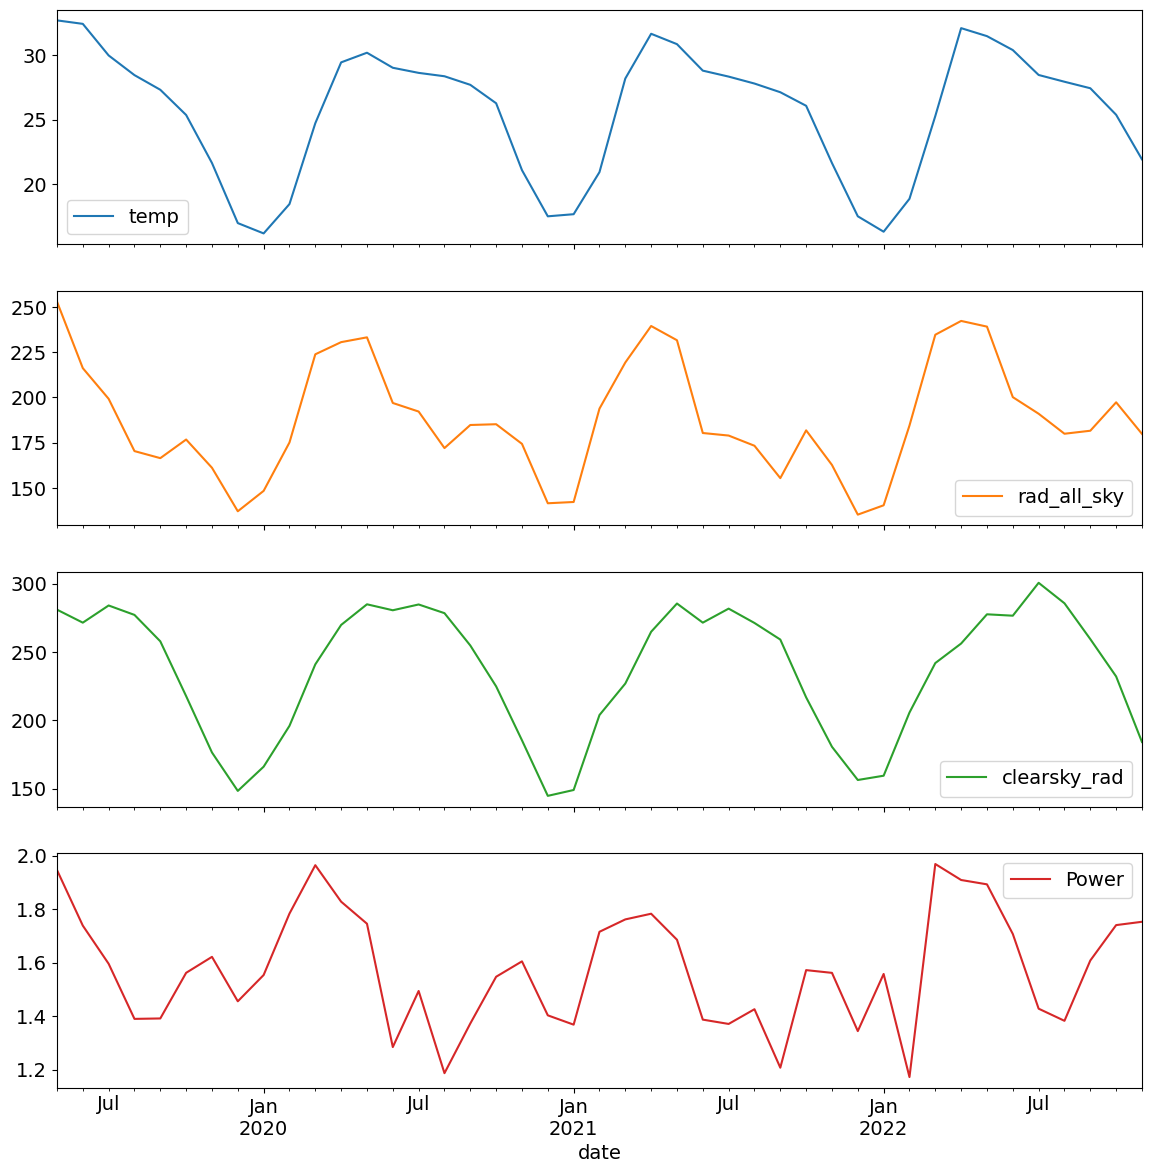

In [123]:
df1.resample('M').mean().plot(subplots=True)# with the resampled data sets it is easier to model and analyse

In [124]:
#saving the resampled datasetin other variable

df1_resampled=df1.resample('M').mean()
# this can be used for df1ing the dataset

In [125]:

#Step#1 : initialise the auto arima function for different parameters, initially for time
# we can say that here the methodology adopted is random  search technique as it is a convenient and faster method
model = pm.auto_arima(df1_resampled['temp'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=94.510, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=94.310, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=96.433, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=91.210, Time=0.35 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=89.273, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=91.273, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=92.475, Time=0.06 sec
 ARIMA

In [126]:
# for other parameters
model = pm.auto_arima(df1_resampled['rad_all_sky'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=272.236, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=243.236, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=252.148, Time=0.04 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=244.275, Time=0.37 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=246.253, Time=1.22 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=259.526, Time=0.07 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=231.712, Time=0.15 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=235.338, Time=0.05 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=233.346, Time=0.65 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=inf, Time=

In [127]:
model = pm.auto_arima(df1_resampled['clearsky_rad'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=235.610, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=223.510, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=230.608, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=224.187, Time=0.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=226.187, Time=0.41 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=226.465, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=221.954, Time=0.14 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=227.611, Time=0.06 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=221.648, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=223.631, Time=1.53 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, T

In [128]:
model = pm.auto_arima(df1_resampled['Power'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-14.542, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-6.861, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-15.316, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-13.612, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=163.929, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-12.575, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-15.242, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-16.118, Time=0.47 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-14.641, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-14.015, Time=0.95 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-14.061, Time=0.81 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-14.015, Time=0.41 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-12.552, Time=1.10 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-14.695, Time=0.51 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept

In [129]:
#splitting the data into train and test

In [130]:
train=df1_resampled[(df1_resampled.index.get_level_values(0) >= '2019-05-31') & (df1_resampled.index.get_level_values(0) <= '2022-04-30')]

In [131]:
train

temp  rad_all_sky  clearsky_rad     Power
date                                                      
2019-05-31  32.679389   252.917903    280.923750  1.946042
2019-06-30  32.409542   216.138569    271.408139  1.738250
2019-07-31  29.966667   199.178280    283.968280  1.595753
2019-08-31  28.443522   170.288266    277.076411  1.389839
2019-09-30  27.310000   166.392889    257.747264  1.391458
2019-10-31  25.359489   176.682930    217.674731  1.561909
2019-11-30  21.644333   161.072944    176.448181  1.621542
2019-12-31  16.996062   137.032460    148.350242  1.455511
2020-01-31  16.197352   148.302984    166.063992  1.553710
2020-02-29  18.466983   175.054124    195.934914  1.783147
2020-03-31  24.722675   223.783199    240.911089  1.963938
2020-04-30  29.431222   230.511806    269.745403  1.827639
2020-05-31  30.176653   233.157245    284.834355  1.745296
2020-06-30  29.012694   196.880681    280.470847  1.284583
2020-07-31  28.617634   192.144516    284.708468  1.494086
2020-08-31  28.355981   171.959220    278.350995  1.187097
2020-09-30  27.692556   184.713917    254.705611  1.372639
2020-10-31  26.266694   185.140040    224.803401  1.547245
2020-11-30  21.091347   174.285514    185.368556  1.604722
2020-12-31  17.520094   141.455349    144.732325  1.403091
2021-01-31  17.683790   142.158763    149.008992  1.368280
2021-02-28  20.938363   193.757664    203.839673  1.715179
2021-03-31  28.180013   219.249315    226.861210  1.761425
2021-04-30  31.642250   239.419750    264.744000  1.782639
2021-05-31  30.840309   231.556452    285.403226  1.685484
2021-06-30  28.790500   180.280208    271.413403  1.387083
2021-07-31  28.329328   178.877702    281.668253  1.370968
2021-08-31  27.792083   173.238750    271.177648  1.425941
2021-09-30  27.120028   155.348083    259.041528  1.207514
2021-10-31  26.071008   181.757070    216.772218  1.571976
2021-11-30  21.641583   162.621986    180.621875  1.561736
2021-12-31  17.521989   135.171008    156.334234  1.344220
2022-01-31  16.329718   140.334355    159.461263  1.557634
2022-02-28  18.874747   184.409301    205.647009  1.172515
2022-03-31  25.280027   234.600766    241.852487  1.968266
2022-04-30  32.078417   242.229889    256.153972  1.908597

In [132]:
test=df1_resampled[(df1_resampled.index.get_level_values(0) > '2022-04-30')]

In [133]:
test

temp  rad_all_sky  clearsky_rad     Power
date                                                      
2022-05-31  31.459382   239.085323    277.515995  1.892392
2022-06-30  30.382819   200.109375    276.498875  1.707000
2022-07-31  28.455457   190.931452    300.551882  1.427970
2022-08-31  27.931828   179.880524    285.574798  1.382634
2022-09-30  27.428889   181.540972    259.373625  1.607917
2022-10-31  25.375202   197.253051    232.047379  1.740134
2022-11-30  21.928314   179.805988    184.117151  1.752529

In [134]:
#fitting the auto ARIMA model
model.fit(train['temp'])


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [135]:
model.fit(train['rad_all_sky'])


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [136]:
model.fit(train['clearsky_rad'])


ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [137]:
model.fit(train['Power'])

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [138]:
# predictions of ARIMA model using the test series
prediction_model=model.predict(n_periods=7, return_conf_int=True)

In [139]:
prediction_model

(2022-05-31    1.715881
 2022-06-30    1.468988
 2022-07-31    1.479602
 2022-08-31    1.432412
 2022-09-30    1.374748
 2022-10-31    1.565706
 2022-11-30    1.575988
 Freq: M, dtype: float64,
 array([[1.37840978, 2.05335143],
        [1.12430498, 1.81367059],
        [1.13460877, 1.82459467],
        [1.08740573, 1.7774186 ],
        [1.02974065, 1.71975469],
        [1.22069886, 1.91071294],
        [1.23098062, 1.92099471]]))

In [140]:
# converting predicted values to pandas date frame
prediction_model_df = pd.DataFrame(prediction_model[0],index = test.index,columns=['Prediction'])

In [141]:
prediction_model_df

Prediction
date                  
2022-05-31    1.715881
2022-06-30    1.468988
2022-07-31    1.479602
2022-08-31    1.432412
2022-09-30    1.374748
2022-10-31    1.565706
2022-11-30    1.575988

<Axes: xlabel='date'>

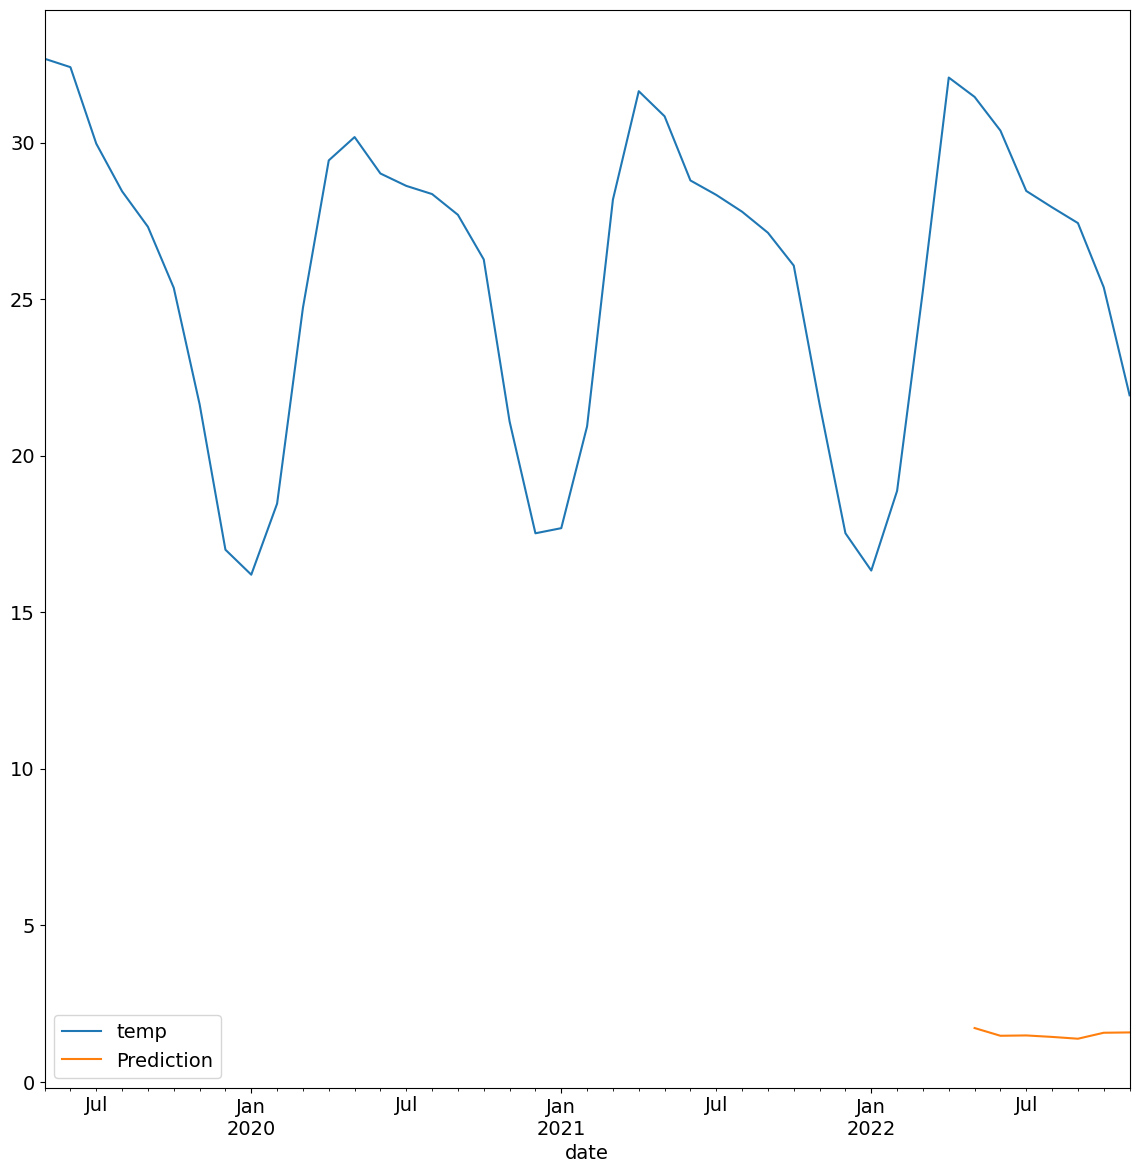

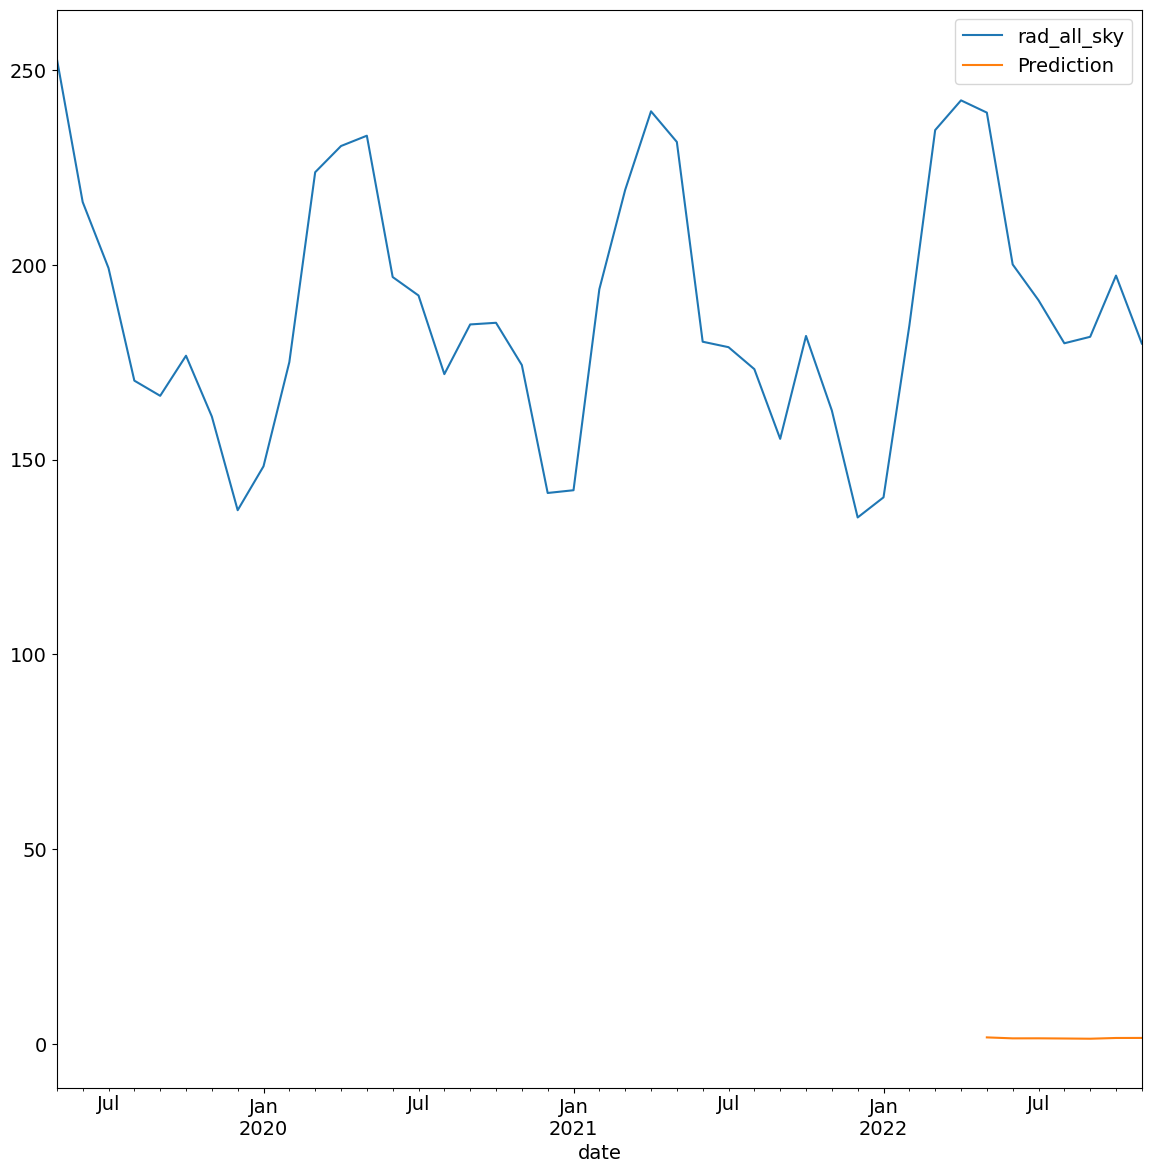

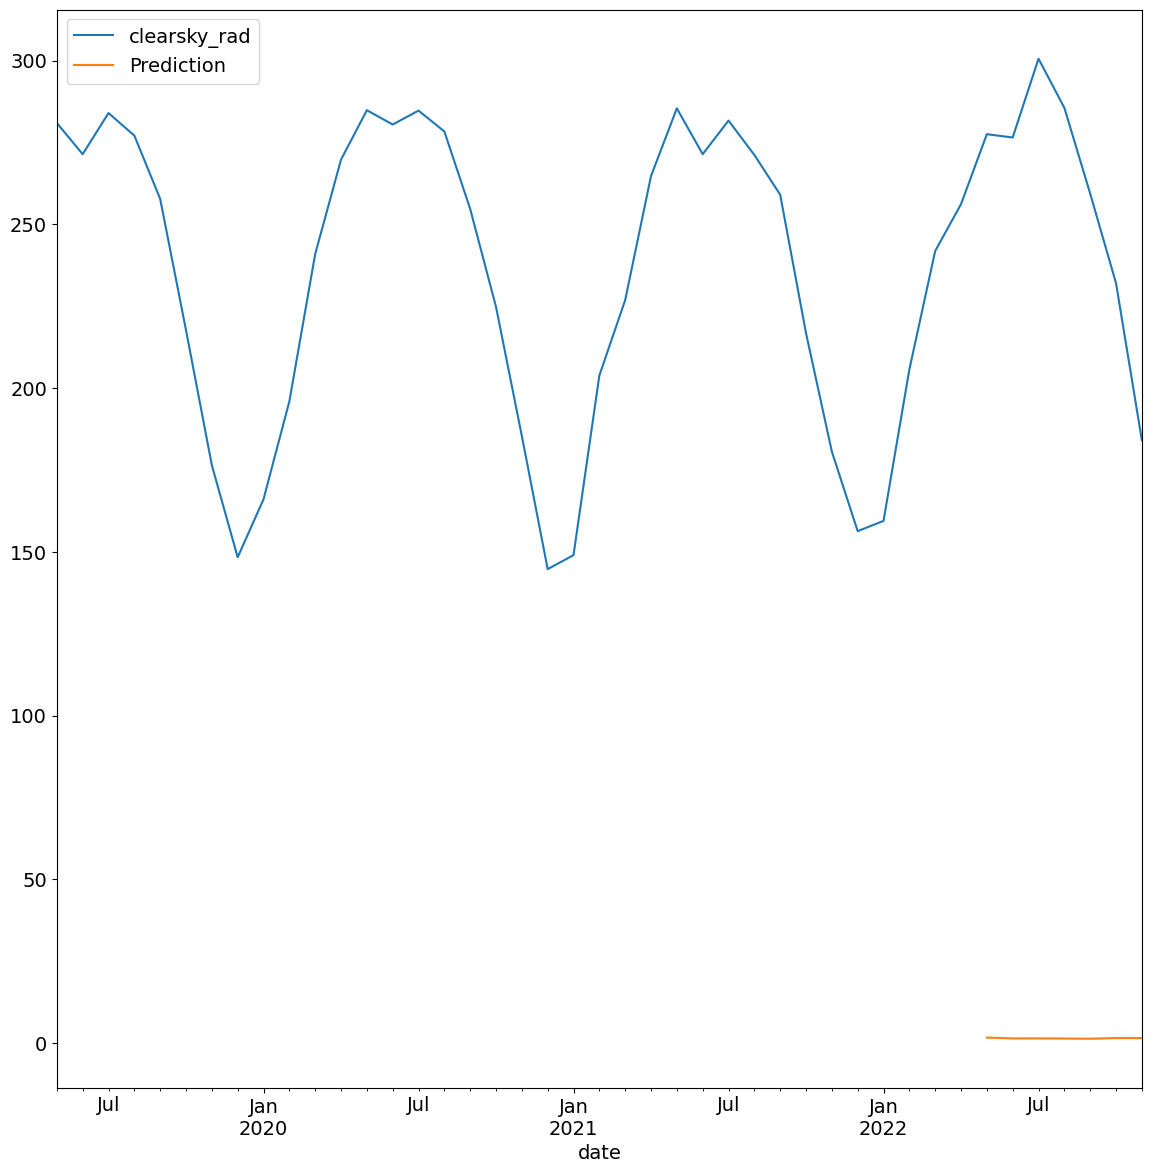

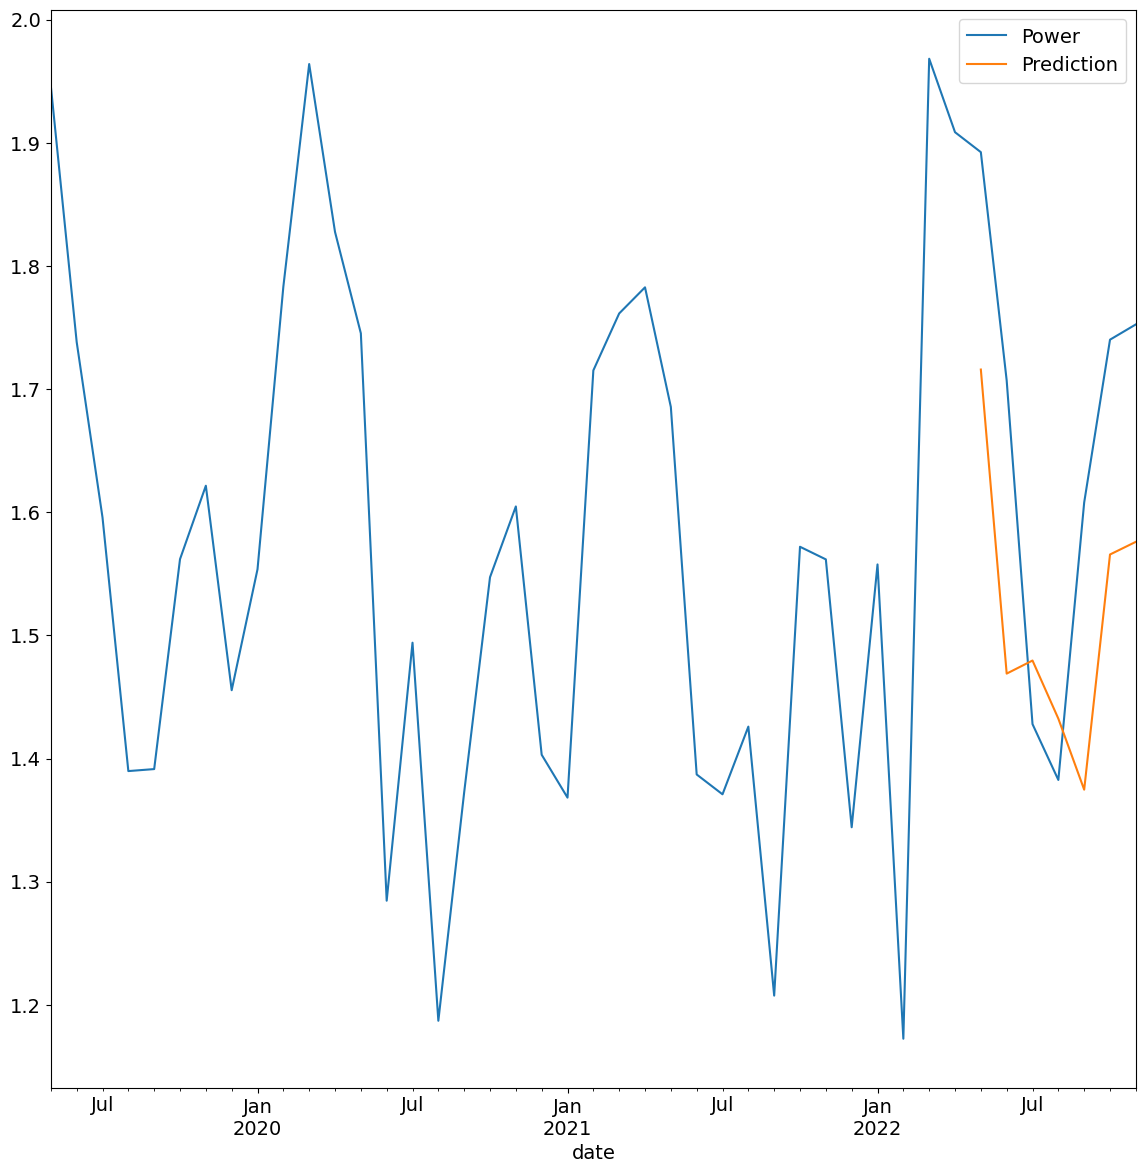

In [142]:
#plotting the Pandas data

pd.concat([df1_resampled['temp'],prediction_model_df],axis=1).plot()
pd.concat([df1_resampled['rad_all_sky'],prediction_model_df],axis=1).plot()
pd.concat([df1_resampled['clearsky_rad'],prediction_model_df],axis=1).plot()
pd.concat([df1_resampled['Power'],prediction_model_df],axis=1).plot()


In [ ]:
#conclusion #only Power has been predicted somewhat accurately
#model could not use the correlation of other parameters with power
#all other parameters except power could not be forecasted with pretty ghood accuracy
